# Анализ спроса на самокаты в сервисе шеринга

## О проекте

Этот проект посвящен изучению спроса на самокаты с целью оптимизации бизнес-процессов и повышения эффективности работы сервиса.  
В ходе исследования будет обработана информация о поездках, погодных условиях и проверена гипотеза о влиянии различных факторов на уровень спроса.

## Цель проекта

Главная цель проекта — выявить, какие факторы влияют на спрос в сервисе.

## План исследования

### Анализ данных
- Изучение качества данных.  
- Выявление аномалий и пропусков.  
- Предварительная обработка информации.

### Расчеты и исследования
- Определение итоговой стоимости поездок и оценка эффективности акций.  
- Анализ почасового трафика и популярности точек аренды.  
- Исследование влияния погодных условий на спрос.

### Проверка гипотез
- Оценка влияния дождя, дня недели и других факторов на спрос и продолжительность поездок.

### Регрессионное моделирование
- Прогнозирование спроса на основе временных и погодных факторов.

### Визуализация
- Создание дашборда для мониторинга ключевых показателей.  
- Презентация основных выводов.

## Ожидаемые результаты

В результате выполнения проекта будут получены следующие результаты:

- Рекомендации по оптимизации работы сервиса.  
- Инсайты о влиянии погоды, времени суток и других факторов на уровень спроса.  
- Дашборд для мониторинга ключевых показателей.

## <span style="color:#00008B">Подключение библиотек</span>

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

**Обратите внимание! Для коректной работы билиотеки "ydata-profiling" нужен python ниже версии 3.13.0.**

In [168]:
# !pip install -U ydata-profiling

In [169]:
from ydata_profiling import ProfileReport

# <span style="color:#8B0000">Спринт 1 - предобработка</span>

## <span style="color:#00008B">Путь до папки </span>

In [170]:
current_dir = os.getcwd()
print(current_dir)
PATH_OUT = current_dir

df  = pd.read_csv(PATH_OUT+"//csv/rides.csv", 
                 sep=',', encoding='utf-8', decimal=',')
df2 = pd.read_csv(PATH_OUT+"//csv/weather.csv", 
                 sep=',', encoding='utf-8', decimal=',')

C:\Users\mailm\Yandex_AD_scooters\Jupyter notebooks


## <span style="color:#00008B">Полезные функции для работы  </span>

In [171]:
def clean_data_with_threshold(df, variable, threshold, flag):
    """
    Очищает DataFrame, удаляя значения в указанной переменной, которые находятся за пределами заданного порога.
    Создает boxplot до и после очистки.

    Args:
        df (pd.DataFrame): Входной DataFrame.
        variable (str): Название столбца для очистки.
        threshold (float): Пороговое значение.
        flag (str):  Если 'below', удаляет значения меньше порога.
                     Если 'above', удаляет значения больше порога.
                     Если 'both', удаляет значения как меньше, так и больше порога (нужен кортеж из двух значений).

    Returns:
        pd.DataFrame: Очищенный DataFrame.
    """

    # Boxplot до очистки
    plot_numeric_boxplots(df)

    # Очистка данных
    if flag == 'below':
        cleaned_df = df[df[variable] >= threshold].copy()
    elif flag == 'above':
        cleaned_df = df[df[variable] <= threshold].copy()
    elif flag == 'both':
        cleaned_df = df[(df[variable] >= threshold[0]) & (df[variable] <= threshold[1])].copy()
    else:
        raise ValueError("Недопустимое значение флага. Должно быть 'below', 'above' или 'both'.")


    # Boxplot после очистки
    plot_numeric_boxplots(cleaned_df)
    
    return cleaned_df

## <span style="color:#00008B">Графики для просмотра данных </span>

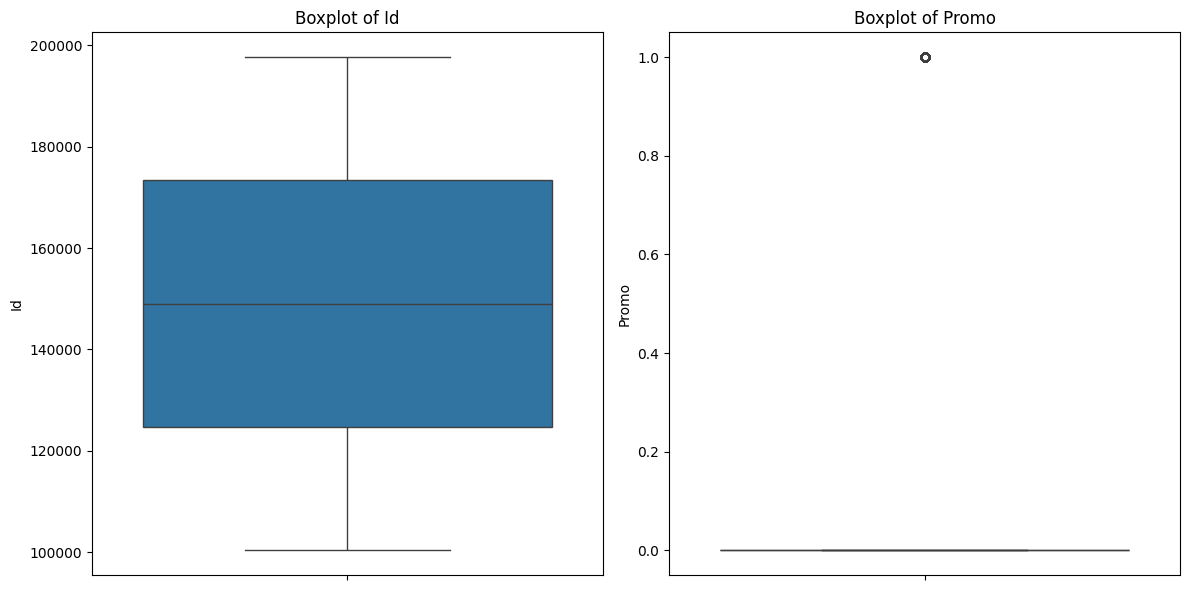

In [172]:
def plot_numeric_boxplots(df, figsize=(12, 6), plot_per_row=2):
    """
    Строит boxplot'ы для всех числовых столбцов в DataFrame.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Входной DataFrame с данными
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах, по умолчанию (12, 6)
    plot_per_row : int, optional
        Количество boxplot'ов в одной строке, по умолчанию 2
    
    Возвращает:
    --------
    None
        Отображает графики, но не возвращает значений
    """
    # Выбираем все числовые столбцы (включая int, float и другие числовые типы)
    numeric_columns = df.select_dtypes(include=['number']).columns
    n_columns = len(numeric_columns)
    
    if n_columns == 0:
        print("No numeric columns found in the DataFrame")
        return
    
    # Вычислить необходимое количество строк
    n_rows = (n_columns + plot_per_row - 1) // plot_per_row
    
    # Создание подзаголовков
    fig, axes = plt.subplots(n_rows, plot_per_row, figsize=(figsize[0], figsize[1] * n_rows))
    
    # Сгладить массив осей для упрощения итерации
    axes = np.array(axes).flatten()
    
    # Создание коробочных графиков
    for idx, column in enumerate(numeric_columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column}')
        axes[idx].set_ylabel(column)
    
    # Удалить пустые подзаголовки, если таковые имеются
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# df = pd.DataFrame(your_data)
plot_numeric_boxplots(df)
# plot_numeric_boxplots(df2) - No numeric columns found in the DataFrame

## <span style="color:#00008B">Просмотр имеюшихся данных  </span>

#### <span style="color:#006400">Данные в rides.csv</span>

In [173]:
df.head(5)

,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


In [174]:
#Анализирует DataFrame: проверяет пропуски, дубликаты, выводит статистику и примеры данных для числовых и категориальных столбцов
def check_data(data_df):
    print ('\033[5m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Id              102255 non-null  int64 
 1   Start Date      102255 non-null  object
 2   End Date        102255 non-null  object
 3   Start Location  102255 non-null  object
 4   Start District  102255 non-null  object
 5   End Location    102255 non-null  object
 6   End District    102255 non-null  object
 7   Distance        101022 non-null  object
 8   Promo           102255 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 7.0+ MB
None

Проверка пропусков
Количество пропусков: 1233
Доля пропусков: 0.2%
Доля строк содержащих пропуски: 1.2%

Проверка на дубликаты
Количество полных дубликатов:  4883

Первые пять строк датасета


,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
Id,102255.0,149024.057679,28110.574992,100340.0,124682.5,149028.0,173372.5,197711.0
Promo,102255.0,0.019755,0.139156,0.0,0.0,0.0,0.0,1.0



Описание категориальных данных:


,count,unique,top,freq
Start Date,102255,96526,2023-07-02 11:35:14,4
End Date,102255,95949,NaT,579
Start Location,102255,463,Ломоносова,1675
Start District,102255,13,Центральный,18115
End Location,102255,495,Спортивная,1511
End District,102255,14,Центральный,18878
Distance,101022,6535,4.0,1162



Вывод уникальных значений по каждому категориаьному признаку:
_Start Date


Start Date
2023-07-02 11:35:14    4
2023-07-15 18:09:14    4
2023-06-03 15:07:27    3
2023-06-02 20:02:05    3
2023-06-03 15:40:44    3
                      ..
2023-07-31 22:55:48    1
2023-07-31 22:57:28    1
2023-07-31 23:10:07    1
2023-07-31 23:12:40    1
2023-04-22 09:19:13    1
Name: count, Length: 96526, dtype: int64

_End Date


End Date
NaT                    579
2023-05-20 19:58:25      4
2023-05-17 19:30:32      4
2023-06-18 18:42:24      4
2023-07-03 20:07:12      4
                      ... 
2023-07-31 23:16:03      1
2023-07-31 23:13:04      1
2023-07-31 23:23:49      1
2023-07-31 23:33:50      1
2023-04-22 09:49:56      1
Name: count, Length: 95949, dtype: int64

_Start Location


Start Location
Ломоносова           1675
Луговая              1655
Майская              1648
Восточная            1584
Спортивная           1583
                     ... 
Ул. Московская          1
Ул. Северная            1
Ул. Энтузиастов         1
Ул. Матросова           1
Ул. Комсомольская       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
Центральный        18115
Юго-Восточный      13542
Ленинский          11308
Северо-Западный    11304
Октябрьский         9729
центральный         8259
Заречный            6803
юго-восточный       5869
ленинский           5011
северо-западный     4973
октябрьский         4330
заречный            3011
северо западный        1
Name: count, dtype: int64

_End Location


End Location
Спортивная      1511
Восточная       1450
Ломоносова      1441
Буденного       1406
Луговая         1405
                ... 
ул почтовая        1
Ул. Заречная       1
Ул. Мичурина       1
Ул. Шевченко       1
ул матросова       1
Name: count, Length: 495, dtype: int64

_End District


End District
Центральный        18878
Юго-Восточный      14612
Ленинский          12090
Северо-Западный    12055
Октябрьский        10519
Заречный            7023
центральный         6808
юго-восточный       5203
северо-западный     4411
ленинский           4308
октябрьский         3794
заречный            2499
Северо Западный       33
северо западный       22
Name: count, dtype: int64

_Distance


Distance
4.0       1162
3.0        980
5.0        524
2.0        239
6.0        153
          ... 
6636.0       1
1645.0       1
6917.0       1
8338.0       1
8604.0       1
Name: count, Length: 6535, dtype: int64

#### <span style="color:#006400">Данные в weather.csv</span>

In [175]:
df2.head(5)

,Datetime,Temperature,Precipitation Total,Wind Gust,Wind Speed,Cloud Cover Total,Sunshine Duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0


In [176]:
check_data(df2)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

Проверка пропусков
Количество пропусков: 134
Доля пропусков: 0.6%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,Datetime,Temperature,Precipitation Total,Wind Gust,Wind Speed,Cloud Cover Total,Sunshine Duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0



Описание количественных данных:


,count,unique,top,freq
Datetime,3672,3672,2023-08-31T23:00:00,1
Temperature,3618,1964,27.540245,9
Precipitation Total,3643,36,0,2966
Wind Gust,3673,163,11.5199995,86
Wind Speed,3657,709,4.3349743,36
Cloud Cover Total,3653,197,0,251
Sunshine Duration,3661,495,0,1309



Описание категориальных данных:


,count,unique,top,freq
Datetime,3672,3672,2023-08-31T23:00:00,1
Temperature,3618,1964,27.540245,9
Precipitation Total,3643,36,0,2966
Wind Gust,3673,163,11.5199995,86
Wind Speed,3657,709,4.3349743,36
Cloud Cover Total,3653,197,0,251
Sunshine Duration,3661,495,0,1309



Вывод уникальных значений по каждому категориаьному признаку:
_Datetime


Datetime
2023-08-31T23:00:00    1
2023-04-01T00:00:00    1
2023-04-01T01:00:00    1
2023-04-01T02:00:00    1
2023-04-01T03:00:00    1
                      ..
2023-04-01T12:00:00    1
2023-04-01T11:00:00    1
2023-04-01T10:00:00    1
2023-04-01T09:00:00    1
2023-04-01T08:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245     9
25.610245     8
15.040245     8
11.250245     7
20.140245     6
             ..
15.410245     1
14.290245     1
14.850245     1
13.3102455    1
12.710245     1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
1.8       6
1.7       6
2.2       6
2.1       4
2.4       2
2.3       2
2         2
1.9       2
2.6       2
mm        1
2.9       1
3         1
5         1
5.8       1
3.3       1
3.9       1
3.4       1
2.8       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
67.67999       1
65.520004      1
66.96          1
65.159996      1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743    36
5.3517847    34
6.28713      33
3.319036     33
4.0249224    32
             ..
23.132626     1
25.600533     1
22.42427      1
21.94524      1
22.26477      1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
19.2           1
14.1           1
18.300001      1
14.400001      1
13.500001      1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
2.2343435       1
26.962963       1
19.630304       1
53.81818        1
32.435688       1
Name: count, Length: 495, dtype: int64

## <span style="color:#00008B">Начало предобработки  </span>

### <span style="color:#006400">Данные в rides.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [177]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


#### Вычислим длительность сессии между 'Start Date' и 'End Date' в формате HH:MM:SS и дополнительно в минутах

In [178]:
def calculate_session_time(df):
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df['session_time'] = df['end_date'] - df['start_date']
    df['session_time'] = df['session_time'].apply(
        lambda x: str(x).split()[-1] if 'days' in str(x) else str(x)
    )
    df['session_time_(minutes)'] = pd.to_timedelta(df['session_time']).dt.total_seconds() / 60
    return df

df = calculate_session_time(df)
df.to_csv("datafrem_data.csv")

#### наведем порядок в типах данных

##### Было: 

In [179]:
df.dtypes

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location                    object
start_district                    object
end_location                      object
end_district                      object
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object

##### Стало:

In [180]:
# Преобразование столбцов с локациями в строковый тип (text/string)
location_columns = ['start_location', 'start_district', 'end_location', 'end_district']
df[location_columns] = df[location_columns].astype('string')

# Преобразуем в строку формата HH:MM:SS
df['session_time'] = pd.to_timedelta(df['session_time']).astype(str).str[-8:]
print(df.dtypes)

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location            string[python]
start_district            string[python]
end_location              string[python]
end_district              string[python]
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object


тип данных в session_time можно сделать timedelta, но тогда будут указывать данные в формате дней:часов:минут:секунд а для красоты пока что оставлю 
тип object. (позже улдалить эту колонку(т.к есть Session Time (minutes)))

#### Преведем числовой столбец к целым числам, отбрасывая дробную часть и NaN

In [181]:
def convert_id_column(df, column='distance'):
    df = df.copy()
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.0$', '', regex=True) 
    df[column] = df[column].str.replace('nan', '', regex=True)
    df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

df = convert_id_column(df)

#### Очистим и стандартизируем форматы адресов ()

In [182]:
df['start_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['start_location']))
df['end_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['end_location']))
df['start_district'] = list(map(lambda x: x.lower(), df['start_district']))
df['end_district'] = list(map(lambda x: x.lower(), df['end_district']))
df.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.666667


### <span style="color:#006400">Данные в weather.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [183]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2.head()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0


#### наведем порядок в типах данных

##### Было: 

In [184]:
df2.dtypes

datetime               object
temperature            object
precipitation_total    object
wind_gust              object
wind_speed             object
cloud_cover_total      object
sunshine_duration      object
dtype: object

##### Стало: 

In [185]:
#первую строку надо удалить, чтобы типы преобразовать
units = {
    'temperature': '°C',
    'precipitation_total': 'mm',
    'wind_gust': 'km/h',
    'wind_speed': 'km/h',
    'cloud_cover_total': '%',
    'sunshine_duration': 'min'
}

df2 = df2.iloc[1:].reset_index(drop=True)

df2 = df2.astype({
    'datetime': 'datetime64[ns]',
    'temperature': 'float64',
    'precipitation_total': 'float64',
    'wind_gust': 'float64',
    'wind_speed': 'float64',
    'cloud_cover_total': 'float64',
    'sunshine_duration': 'float64'
})
print(df2.dtypes)
df.head(5)

datetime               datetime64[ns]
temperature                   float64
precipitation_total           float64
wind_gust                     float64
wind_speed                    float64
cloud_cover_total             float64
sunshine_duration             float64
dtype: object


,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes)
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.666667


## <span style="color:#00008B">Посмотрим на дубликаты и пропуски </span>

### <span style="color:#006400">Данные в rides.csv</span>

#### Полные дубликаты и по столбцам

In [186]:
duplicates = df[df.duplicated()]  # keep=False
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 4831 полных дубликатов


In [187]:
df.isna().sum()

id                          0
start_date                  0
end_date                  579
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    579
dtype: int64

при удалении полных дубликатов получим  101022 - 4831 = 96191 строк данных (сейчас показывает 579 пропусков, но после удаления полных дубликатов 
получим 555 пропусков (проверял в другом notebook)) из этого  следует 2 вывода 1) мы можем просто удалить данные пропуски т.к. они составляют 
всего лишь 0,58% от всех данных ((555 * 100)/96191) либо 2) проведем небольшое исследование данных пропусков:    

#### исследование пропусков в end_date 

In [188]:
#Выводит топ-5 стартовых точек поездок с пропущенными датами окончания (end_date)
missing_data = df[df['end_date'].isna()]
print("Типичные стартовые точки для поездок без end_date:")
print(missing_data['start_location'].value_counts().head(5))

Типичные стартовые точки для поездок без end_date:
start_location
спортивная    21
майская       16
восточная     15
ломоносова    13
луговая       13
Name: count, dtype: int64


In [189]:
# Заполнить пропуски средним временем поездки для этих локаций
# for location in ['Спортивная', 'Ломоносова', 'Майская', 'Восточная', 'Чехова']:
#     avg_time = df[df['start_location'] == location]['session_time_(minutes)'].mean()
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'session_time_(minutes)'] = avg_time
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'end_date'] = \
#         df['start_date'] + pd.to_timedelta(avg_time, unit='minutes')

таким образом мы можем заполнить пропуски средним временем поездки для часто встречаюшихся локаций

#### Посмотрим на повторяющиеся значения в других столбцах

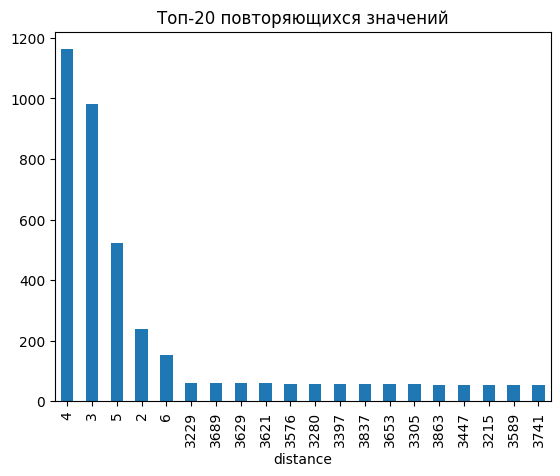

In [190]:
df['distance'].value_counts().head(20).plot(kind='bar')
plt.title("Топ-20 повторяющихся значений")
plt.show()

слишком много значений <100 в колонке distance (нужно посмотреть внимательнее возможно это будут выбросы) (потом мы их очистили см. далее)

#### посмотрим дубликаты в id

In [191]:
duplicate_ids = df.duplicated(subset=['id'], keep=False)
print(f"Найдено {duplicate_ids.sum()} дубликатов по ID")

Найдено 9662 дубликатов по ID


#### Посмотрим на неявные дубликаты

Статистика дублик атов:
{'exact_duplicates': 9662, 'id_duplicates': 9662, 'time_location_duplicates': 9662, 'inconsistent_duplicates': 9614}


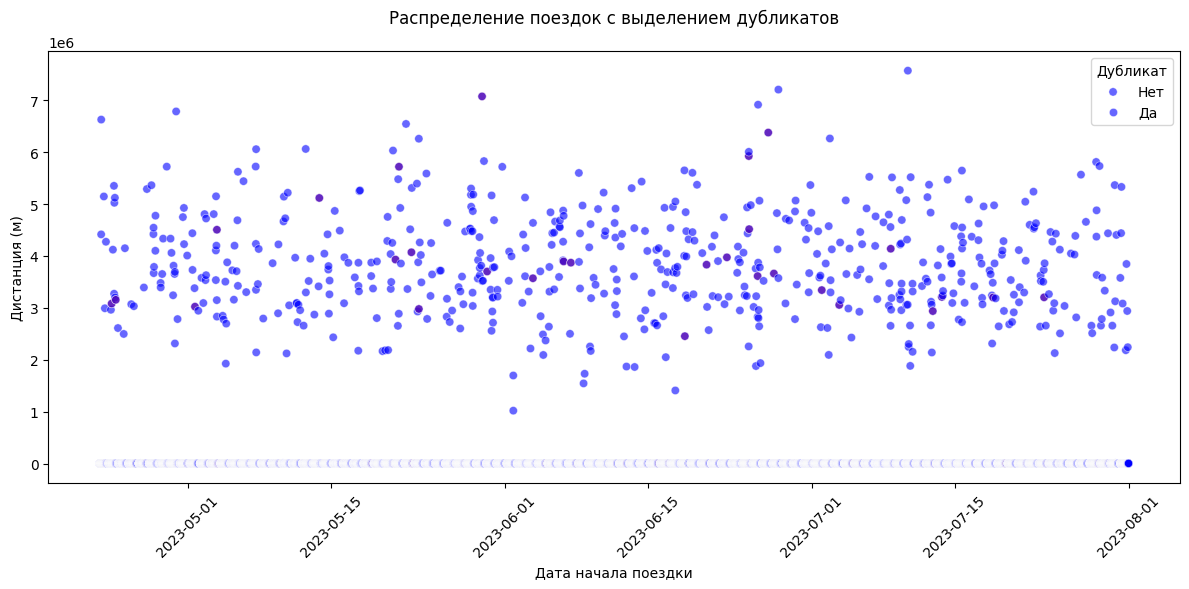

In [192]:
def check_all_duplicates(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о поездках
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по ID
    duplicate_stats = {
        'exact_duplicates': 0,
        'id_duplicates': 0,
        'time_location_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # Дубликаты по ID
    id_duplicates = df[df.duplicated(subset=['id'], keep=False)]
    duplicate_stats['id_duplicates'] = len(id_duplicates)
    
    # 2. Проверка неявных дубликатов
    # По времени и локациям
    time_loc_cols = ['start_date', 'end_date', 
                     'start_location', 'end_location']
    time_loc_duplicates = df[df.duplicated(subset=time_loc_cols, keep=False)]
    duplicate_stats['time_location_duplicates'] = len(time_loc_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['start_date', 'end_date', 
                'start_district', 'end_district',
                'distance']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        id_duplicates,
        time_loc_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates(df, duplicates):
    """
    Визуализация результатов проверки дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график поездок с выделением дубликатов
    ax = sns.scatterplot(
        x='start_date',
        y='distance',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение поездок с выделением дубликатов', pad=20)
    plt.xlabel('Дата начала поездки')
    plt.ylabel('Дистанция (м)')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates(df, duplicates, strategy='keep_first'):
    """
    Очистка данных от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")

duplicates, stats = check_all_duplicates(df)

print("Статистика дублик атов:")
print(stats)

# Визуализация дубликатов
visualize_duplicates(df, duplicates)

# Очистка данных от дубликатов
# cleaned_df = clean_duplicates(df, duplicates, strategy='keep_first')

# print(f"Количество записей после очистки: {len(cleaned_df)}")

Статистика дубликатов:
Exact Duplicates: 0
Id Duplicates: 9662
Time Location Duplicates: 9662
Inconsistent Duplicates: 9614


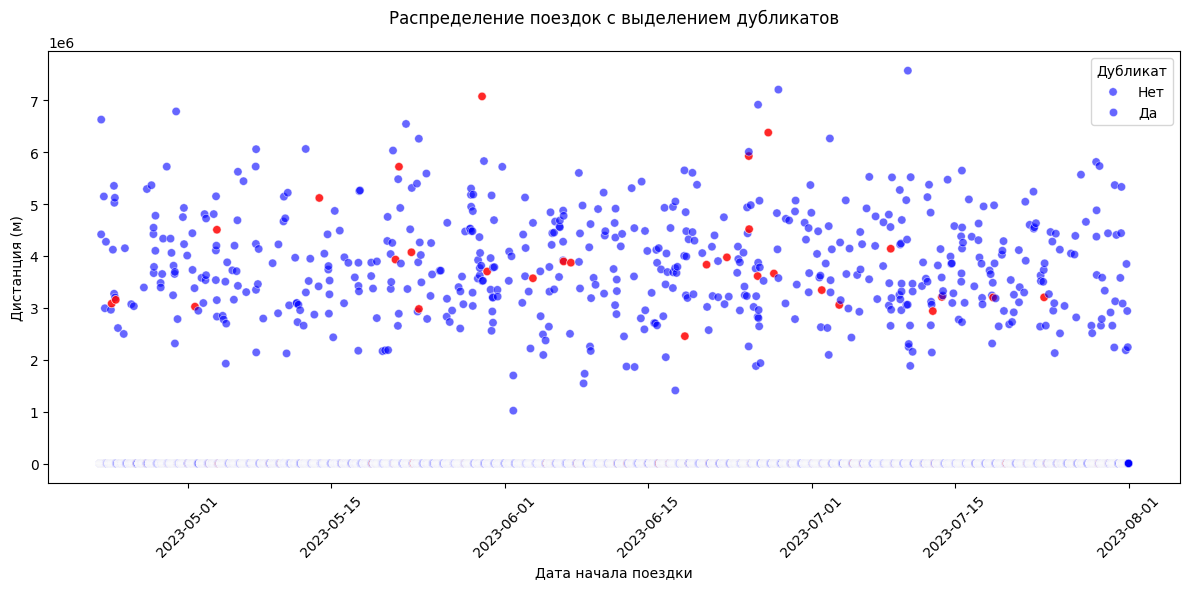

In [193]:
duplicates, stats = check_all_duplicates(df)


print("Статистика дубликатов:")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

# Визуализация
visualize_duplicates(df, duplicates)

#### Посмотрим на выбросы(есть ли они вообще)

Заметим из предыдущего шага, что в distance есть данные <= 100 (250/500/1000)

In [194]:
df[df["distance"] <= 1000]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes),is_duplicate
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,юго-восточный,3,0,00:17:22,17.366667,False
21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5,0,00:29:26,29.433333,False
67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,центральный,5,0,00:52:13,52.216667,False
70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,строительная,северо-западный,строительная,северо-западный,4,0,00:17:54,17.900000,False
108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,центральный,4,0,00:33:28,33.466667,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,центральный,3,0,00:45:56,45.933333,False
102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,чапаева,северо-западный,3,0,00:30:17,30.283333,False
102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,центральный,6,0,00:35:36,35.600000,False
102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,центральный,4,0,00:18:37,18.616667,False


Видно, что в distance	- 3122 значения <= 1000, их стоит считать выбросами  т.к. 
1) Они составляют аномально малую дистанцию по сравнению с основным распределением данных 
2) Могут быть ошибками измерений или техническими артефактами (например, тестовые поездки или сбои GPS)

#### проверим другие столбцы 

In [195]:
df[df["session_time_(minutes)"] >= 60]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes),is_duplicate
357,100679,2023-04-22 16:21:14,2023-04-22 17:30:01,рябиновая,северо-западный,нагорная,центральный,5690,0,01:08:47,68.783333,False
435,100751,2023-04-22 17:09:36,2023-04-22 18:23:37,речная,юго-восточный,спортивная,октябрьский,4466,0,01:14:01,74.016667,False
544,100855,2023-04-22 18:28:51,2023-04-22 19:37:36,майская,октябрьский,солнечная,центральный,5117,0,01:08:45,68.750000,False
564,100874,2023-04-22 18:37:57,2023-04-22 19:43:22,цветочная,северо-западный,комсомольская,заречный,4134,0,01:05:25,65.416667,False
661,100963,2023-04-22 19:28:01,2023-04-22 20:32:09,октябрьская,заречный,комарова,ленинский,6992,0,01:04:08,64.133333,False
...,...,...,...,...,...,...,...,...,...,...,...,...
101366,196863,2023-07-31 08:32:44,2023-07-31 09:45:04,ленина,ленинский,пионерская,заречный,7154,1,01:12:20,72.333333,False
101779,197255,2023-07-31 16:44:38,2023-07-31 17:45:54,озерная,юго-восточный,новая,северо-западный,5537,0,01:01:16,61.266667,False
101839,197313,2023-07-31 17:45:13,2023-07-31 18:53:48,красная,северо-западный,энергетиков,юго-восточный,4935,0,01:08:35,68.583333,False
101929,197397,2023-07-31 18:59:00,2023-07-31 20:06:21,рябиновая,северо-западный,дзержинского,центральный,5144,0,01:07:21,67.350000,False


#### Удалим все не нужное / Заполним все нужное

##### 1) удалим полные дубликаты  (4831 удалаяем)

In [196]:
df = df.drop_duplicates()
df.shape

(96191, 12)

##### 2) заполним пропуски в end_date и session_time_(minutes) (сразу округлим сделав данные красивыми)

In [197]:
df["distance"] = pd.to_numeric(df["distance"], errors="coerce")

# Удаление строк с некорректными расстояниями
df = df.dropna(subset=["distance"])

# Расчет продолжительности поездки в часах
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# Фильтрация валидных записей
valid_mask = (df["duration"] > 0) & (df["distance"] > 0)
valid_entries = df[valid_mask].copy()  # Явное создание копии

# Расчет средней скорости
valid_entries["speed"] = valid_entries["distance"] / valid_entries["duration"]
average_speed = valid_entries["speed"].median()

# Восстановление end_date для дубликатов
duplicate_mask = df.duplicated(subset=["end_date"], keep=False)
df.loc[duplicate_mask, "end_date"] = df.loc[duplicate_mask, "start_date"] + pd.to_timedelta(
    df.loc[duplicate_mask, "distance"] / average_speed, 
    unit="h"
)

df = df.drop(columns=["duration"])

In [198]:
df.isna().sum()

id                          0
start_date                  0
end_date                    0
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    555
is_duplicate                0
dtype: int64

In [199]:
df = calculate_session_time(df)

In [200]:
# Округляем столбец 'session_time_(minutes)' до 6 знаков после запятой
df['session_time_(minutes)'] = df['session_time_(minutes)'].round(1)

# Или до 2 знаков, если нужно:
# df['session_time_(minutes)'] = df['session_time_(minutes)'].round(2)

In [201]:
df.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
is_duplicate              0
dtype: int64

##### 3) удалим  значения которые являються выбросами по колонке distance

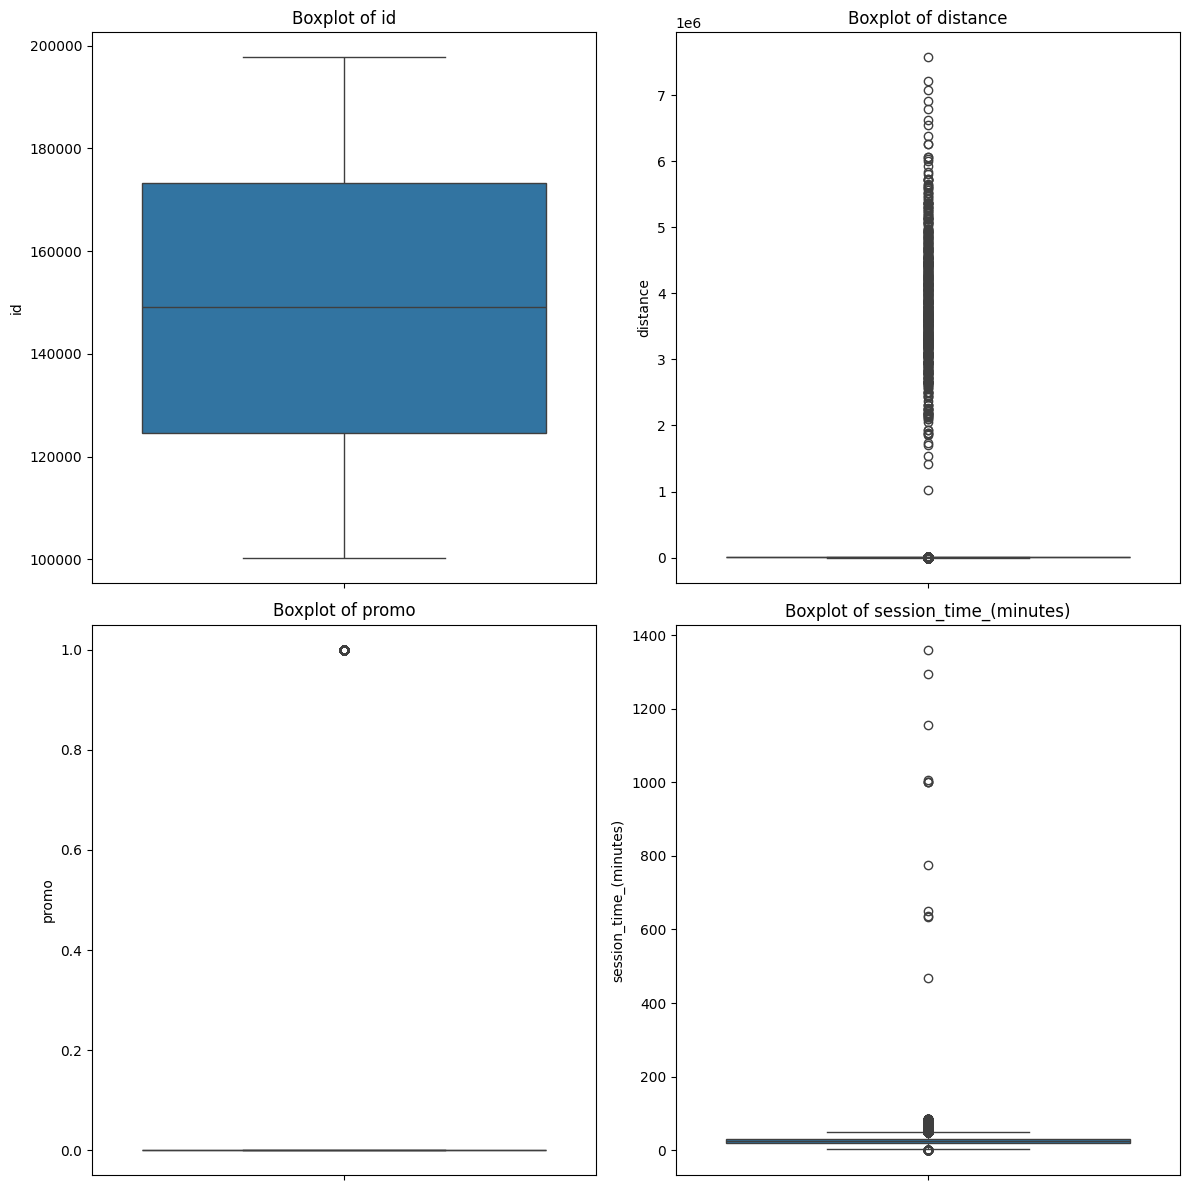

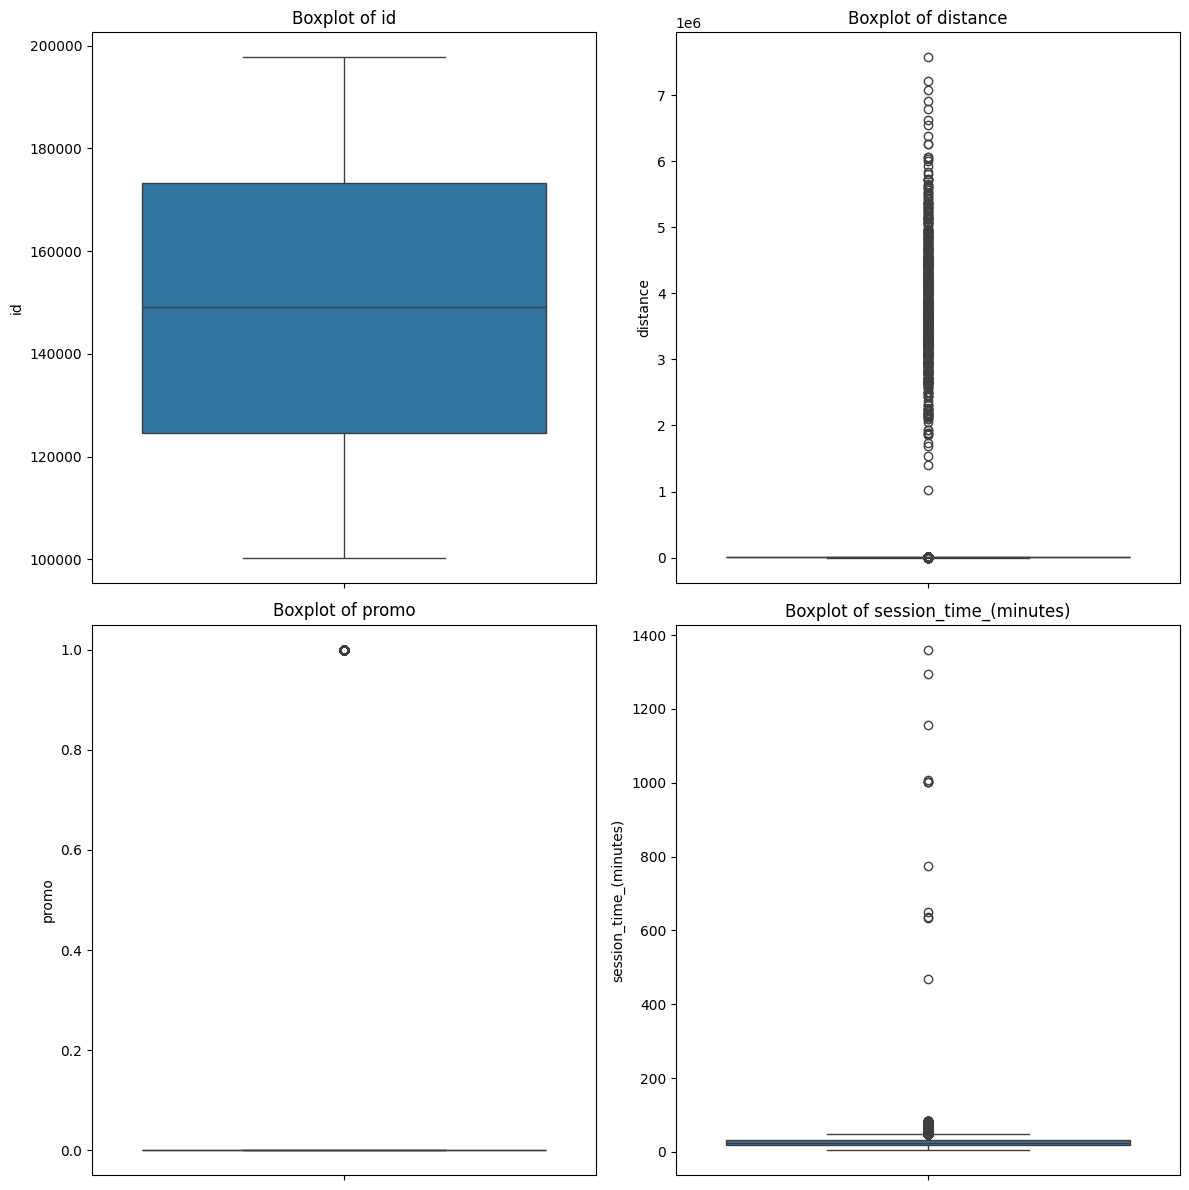

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes),is_duplicate
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0,00:23:42,23.7,False
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0,00:28:25,28.4,False
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0,00:38:19,38.3,False
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0,00:31:49,31.8,False
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0,00:30:40,30.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302,0,00:21:49,21.8,False
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992,0,00:39:34,39.6,False
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781,0,00:21:17,21.3,False
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466,0,00:46:23,46.4,False


In [202]:
df = clean_data_with_threshold(df, "distance", 1000, "below")
df

##### 4)посмотрим и почистим данные в session_time_(minutes)

In [203]:
df[df["session_time_(minutes)"]>=200]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes),is_duplicate
7334,107304,2023-04-30 15:12:50,2023-05-19 23:01:44.748658617,озерная,юго-восточный,чапаева,северо-западный,4227698,0,07:48:54.748658617,468.9,False
10158,110004,2023-05-03 18:18:24,2023-05-27 07:13:18.599306918,комсомольская,заречный,заводская,северо-западный,5149229,0,12:54:54.599306918,774.9,False
10326,110168,2023-05-03 20:21:01,2023-05-16 19:01:11.404371247,свободы,ленинский,южная,центральный,2831768,0,22:40:10.404371247,1360.2,False
12064,111814,2023-05-05 21:39:02,2023-05-31 14:26:04.036526730,заречная,юго-восточный,заводская,северо-западный,5622015,0,16:47:02.036526730,1007.0,False
31853,130683,2023-05-27 15:23:31,2023-06-08 12:57:37.340754690,совхозная,центральный,труда,центральный,2602970,0,21:34:06.340754690,1294.1,False
33911,132635,2023-05-28 21:57:48,2023-06-21 14:39:51.183224684,спортивная,октябрьский,мичурина,ленинский,5183736,0,16:42:03.183224684,1002.1,False
54273,152031,2023-06-17 16:13:03,2023-06-24 02:49:14.667031491,маяковского,центральный,матросова,центральный,1409216,0,10:36:11.667031491,636.2,False
59166,156662,2023-06-22 10:12:20,2023-07-14 02:53:29.989620580,береговая,центральный,озерная,юго-восточный,4746079,0,16:41:09.989620580,1001.2,False
63049,160352,2023-06-25 18:40:07,2023-07-13 11:21:53.179825486,совхозная,центральный,октябрьская,заречный,3871126,0,16:41:46.179825486,1001.8,False
78077,174691,2023-07-09 19:44:58,2023-07-31 06:35:30.514587584,железнодорожная,центральный,чкалова,юго-восточный,4692813,0,10:50:32.514587584,650.5,False


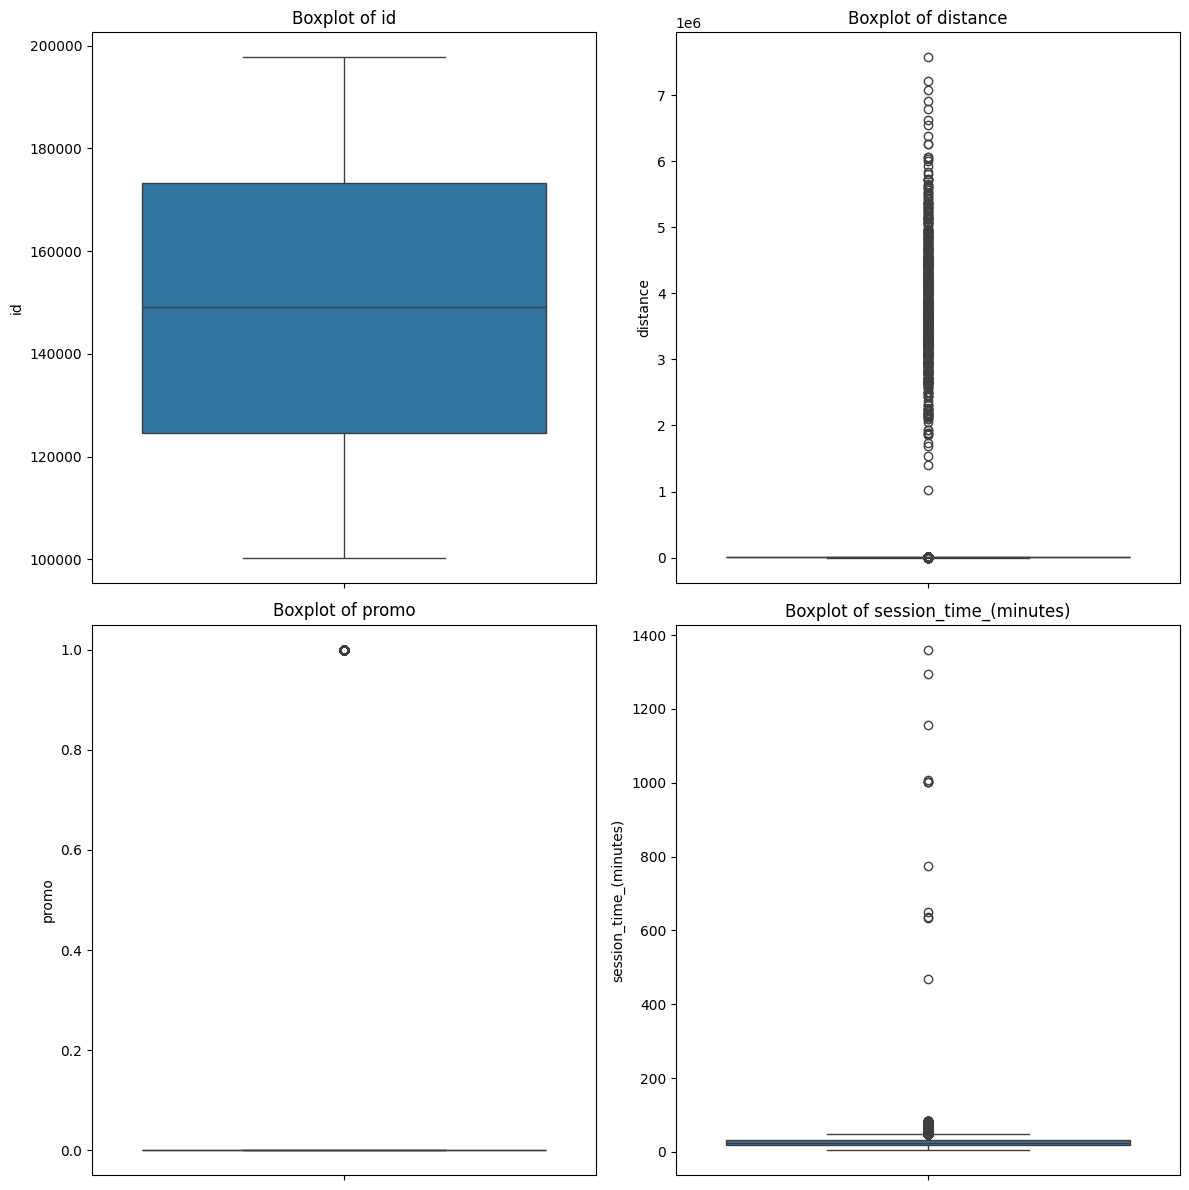

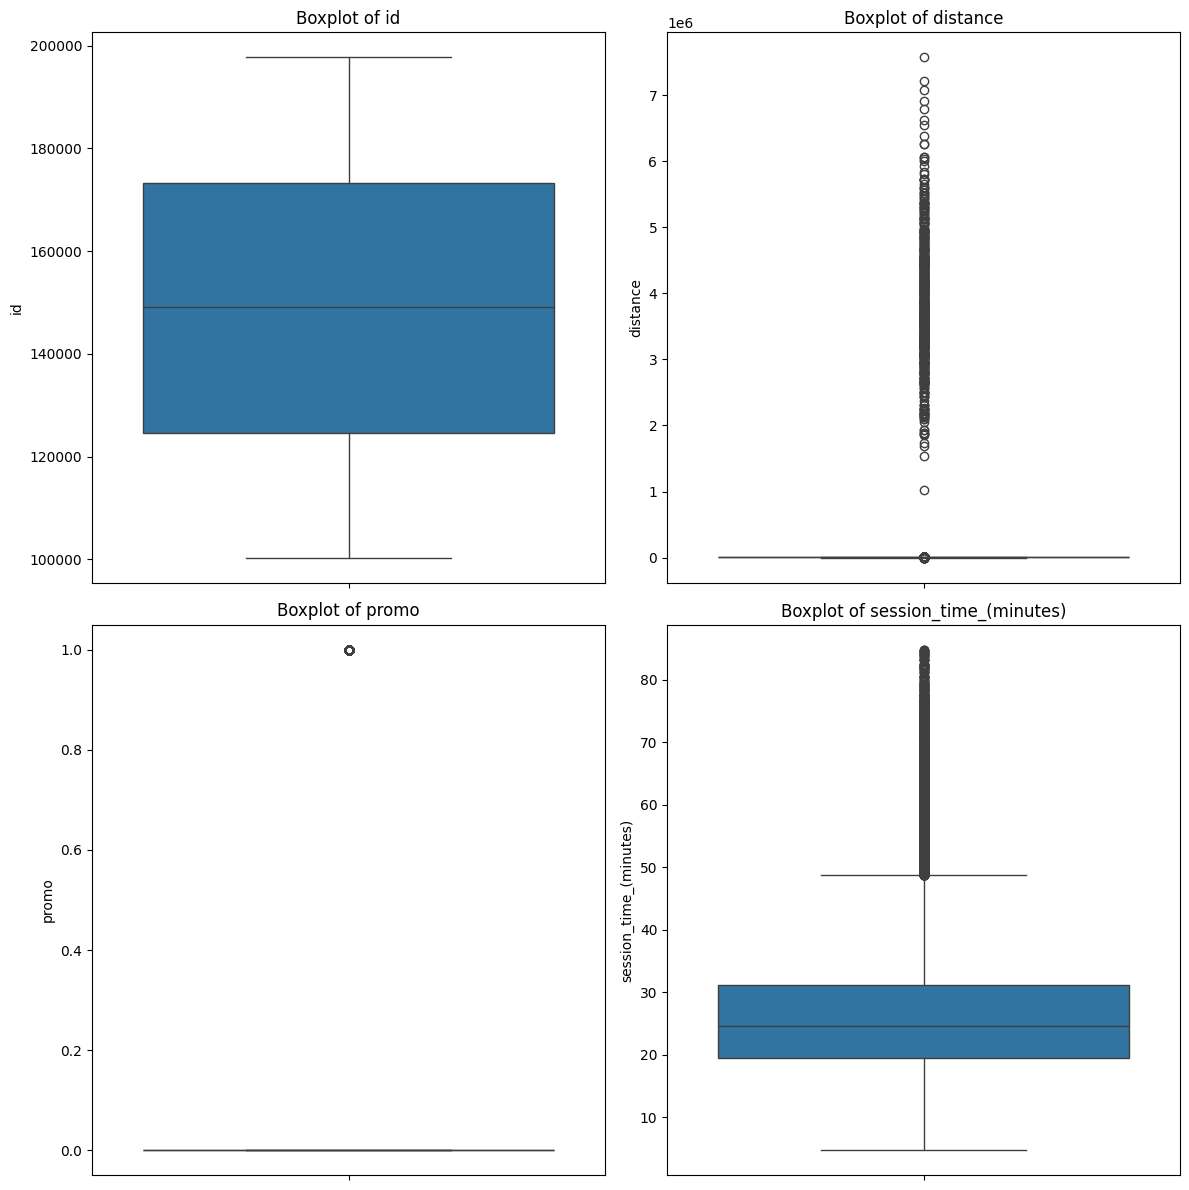

In [204]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

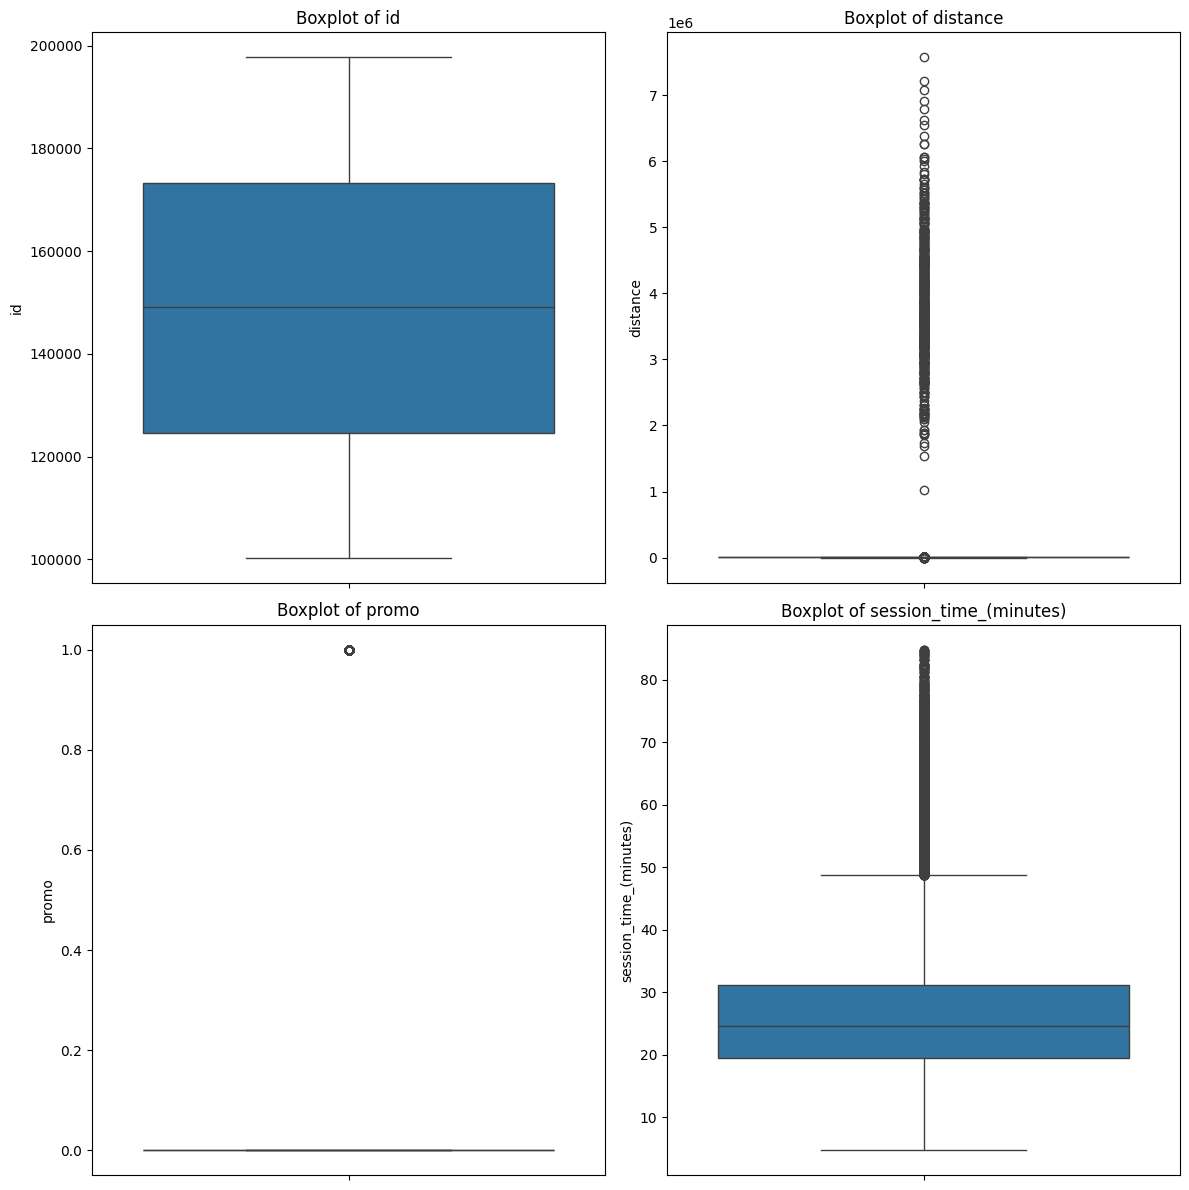

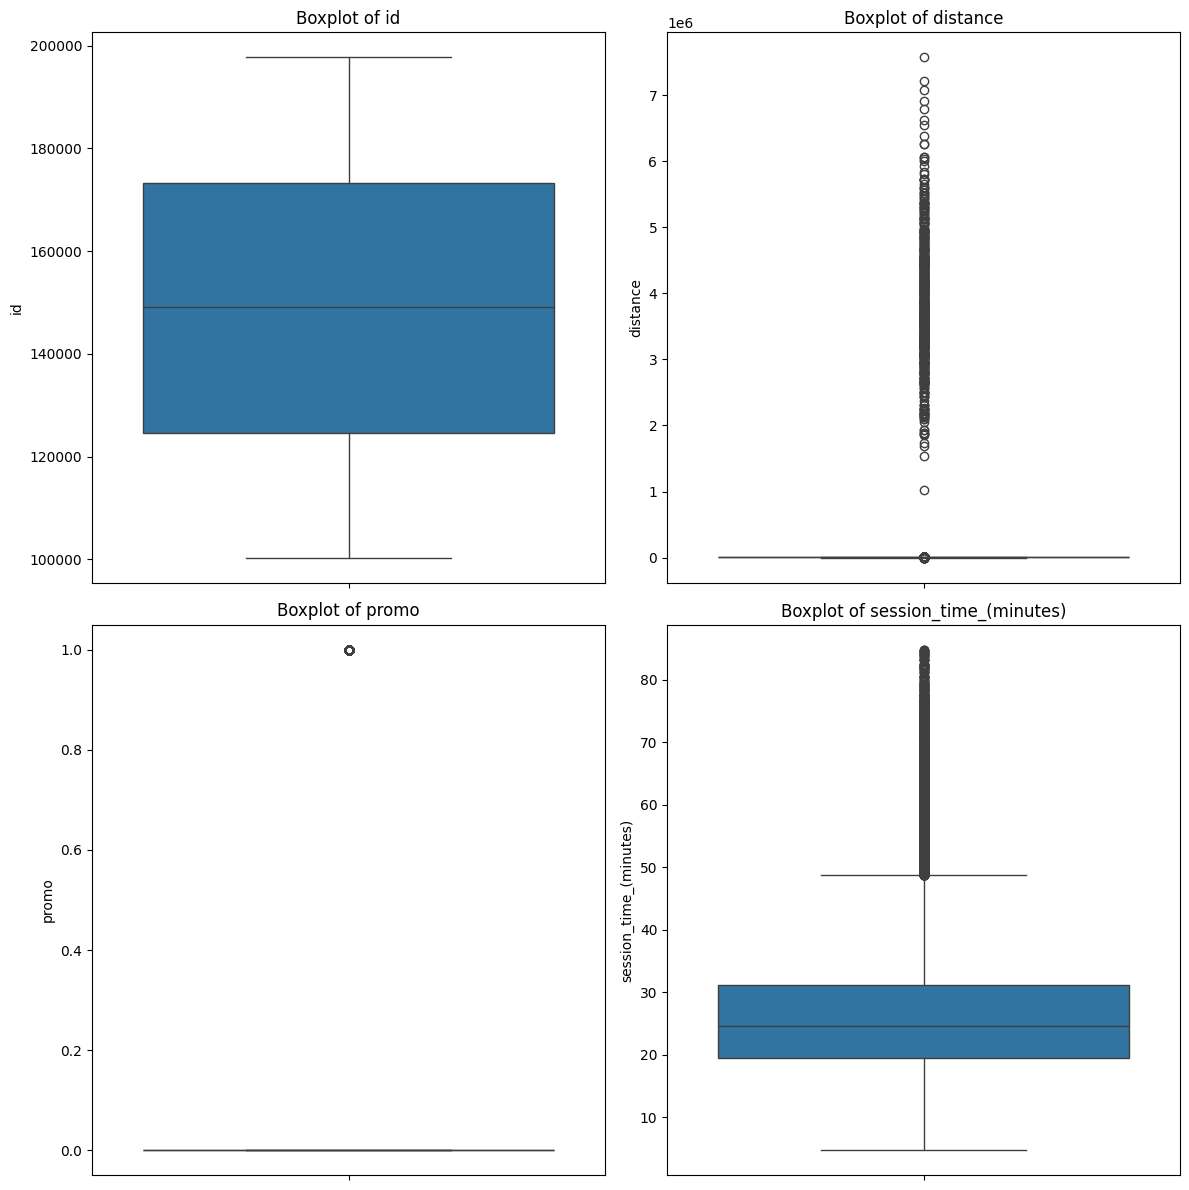

In [205]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 0, "below")

###### Нужно ли убирать долгие поездки?

#### Посмотрим нету ли проблем после удаления 

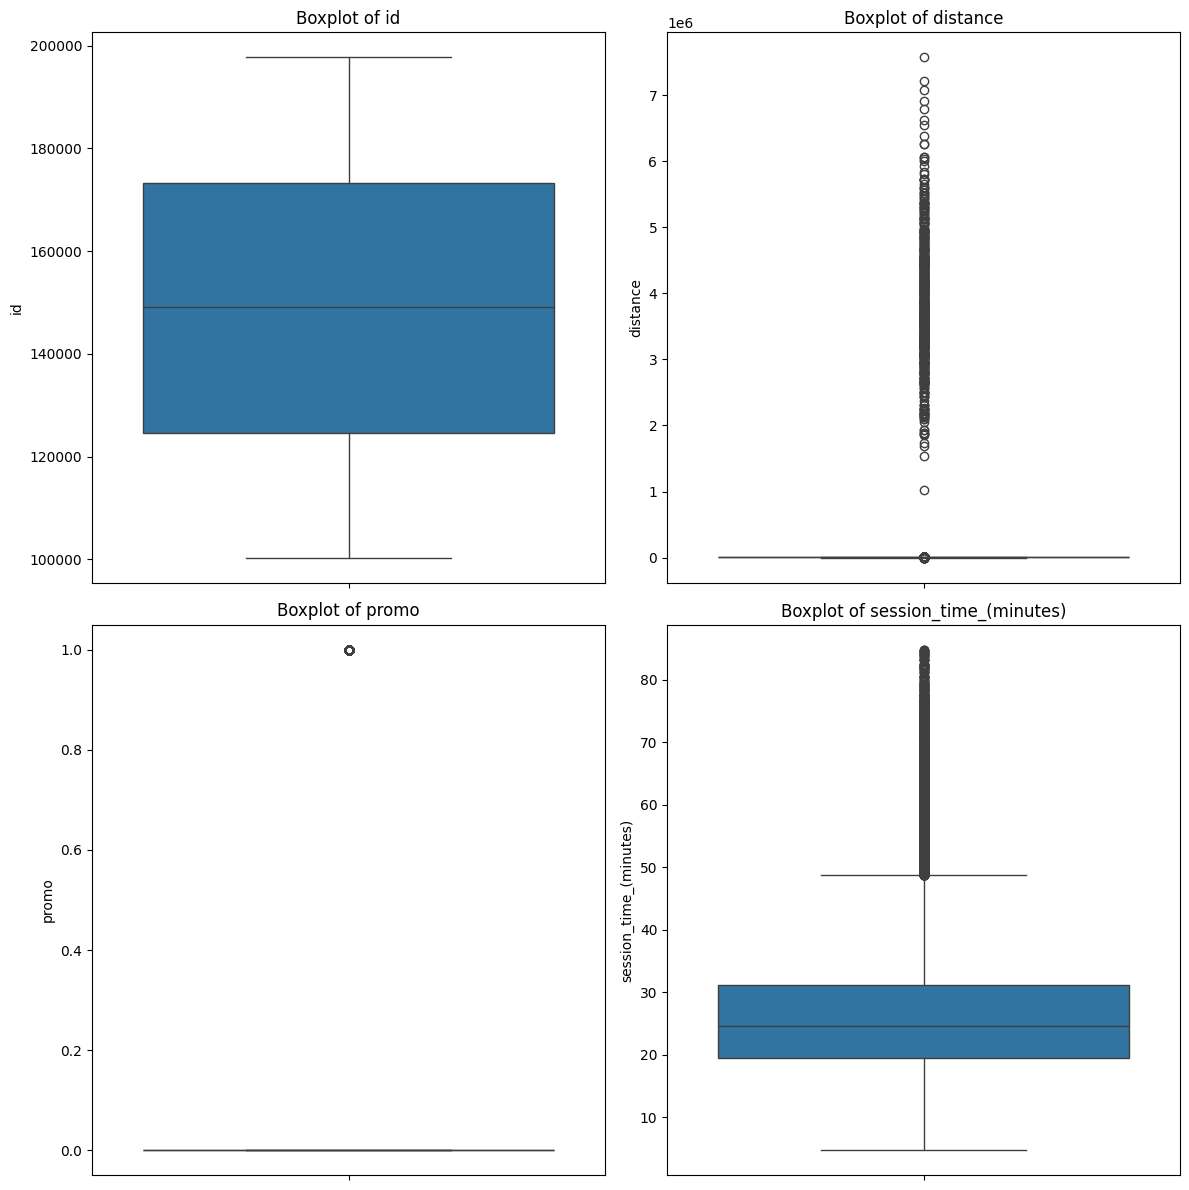

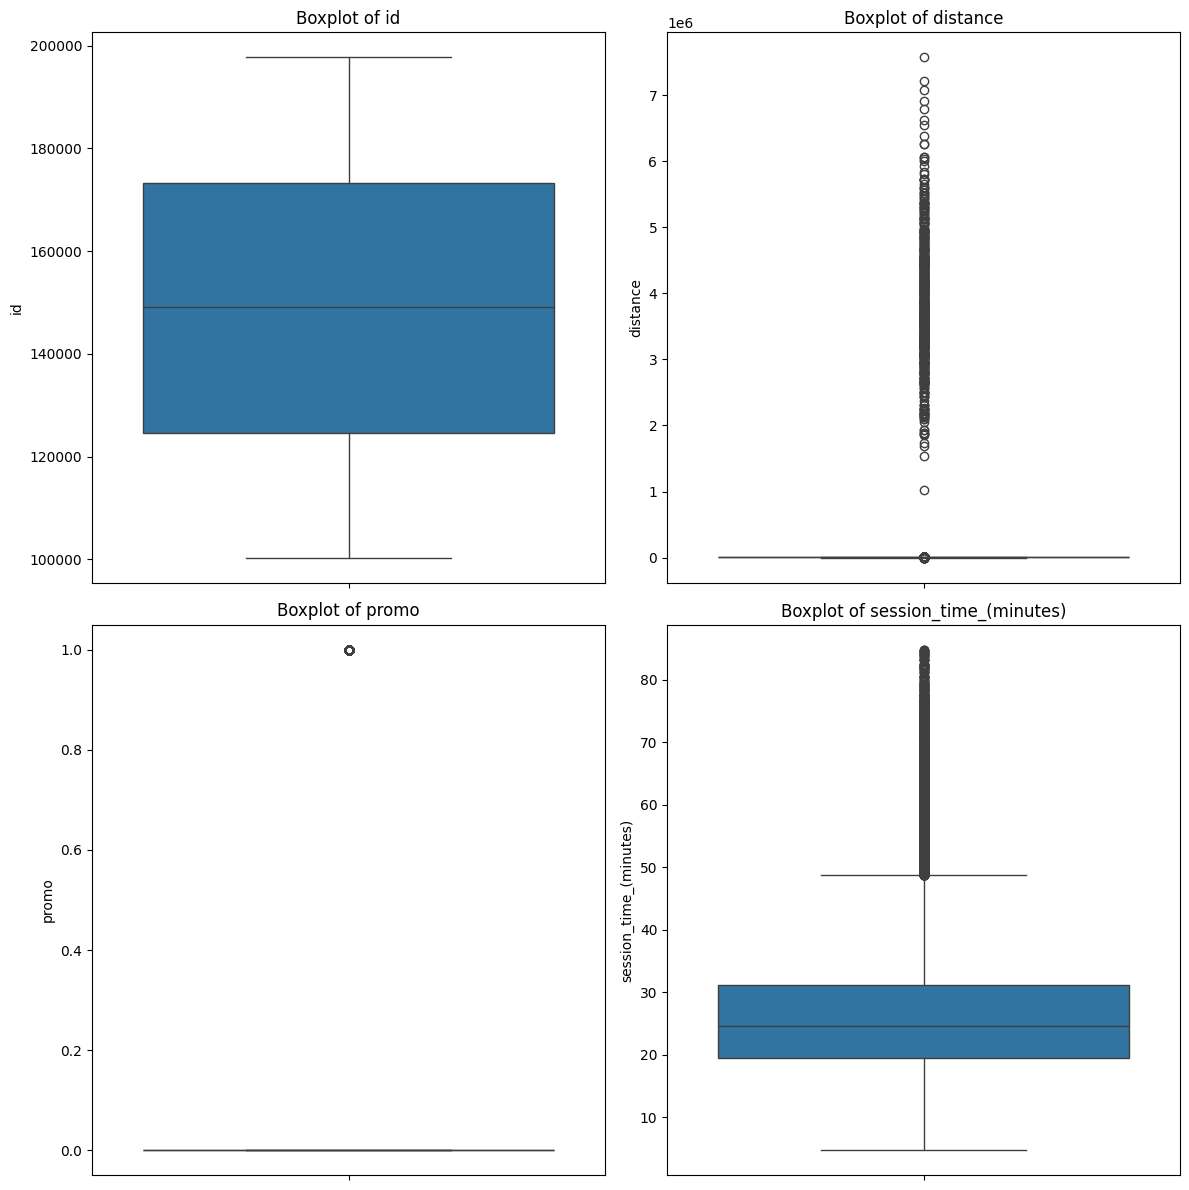

In [206]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

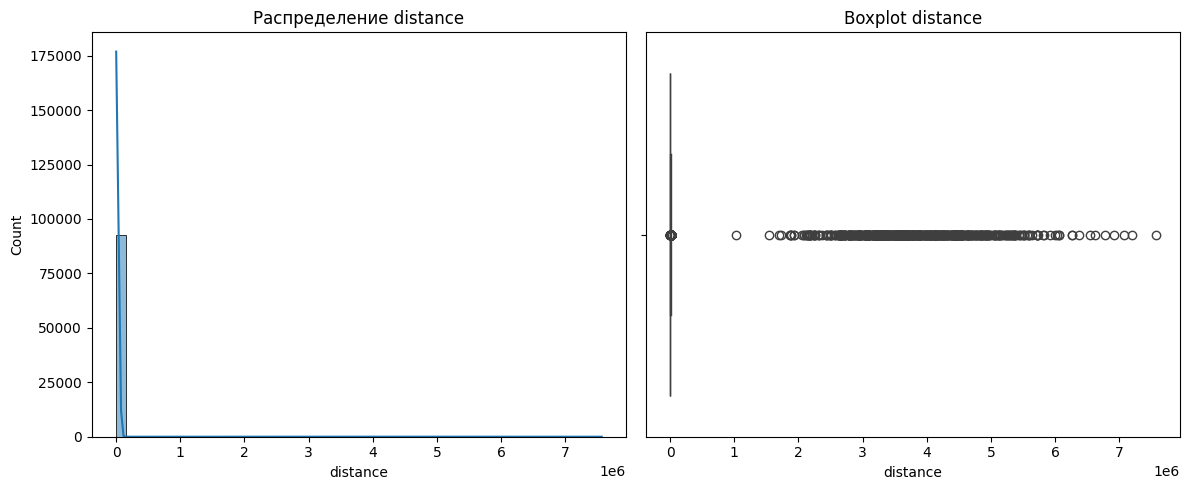

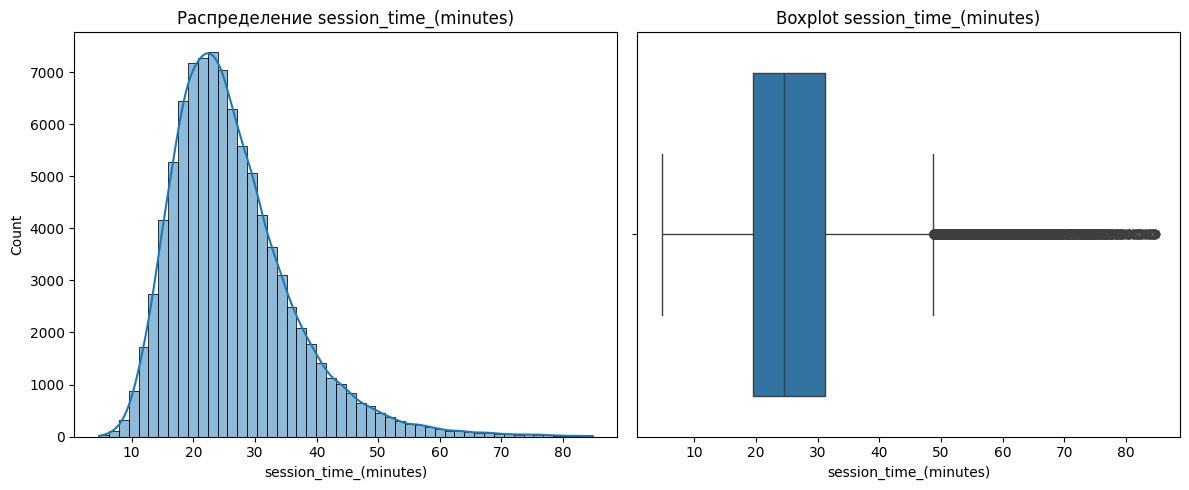

In [207]:
def plot_distribution_with_thresholds(df, column, lower_thresh=None, upper_thresh=None, bins=50):
    """Визуализация распределения с порогами для аномалий"""
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=bins, kde=True)
    if lower_thresh:
        plt.axvline(lower_thresh, color='r', linestyle='--')
    if upper_thresh:
        plt.axvline(upper_thresh, color='r', linestyle='--')
    plt.title(f'Распределение {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot {column}')
    
    plt.tight_layout()
    plt.show()

# Анализ ключевых числовых параметров
for col in ['distance', 'session_time_(minutes)']:
    plot_distribution_with_thresholds(df, col)

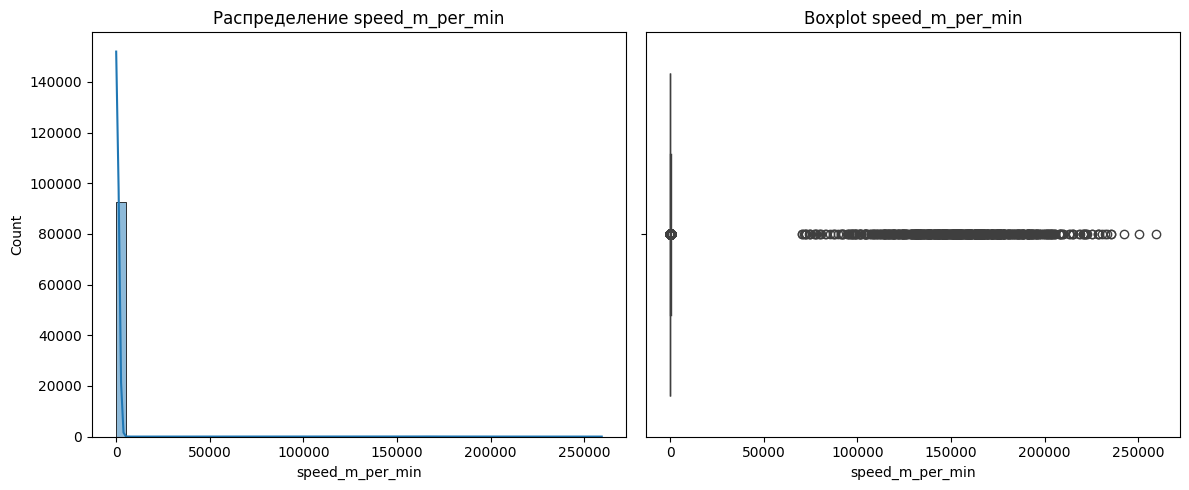

In [208]:
# Добавляем скорость (м/мин)
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']

# Анализ скорости
plot_distribution_with_thresholds(df, 'speed_m_per_min')

# Определяем разумные пороги для скорости (пример)
speed_lower = 10  # 10 м/мин (~0.6 км/ч)
speed_upper = 500  # 500 м/мин (~30 км/ч)

In [209]:
def handle_anomalies(df, strategy='replace_with_nan'):
    """Обработка аномальных значений"""
    
    # Пороги для разных параметров (настраиваются по данным)
    thresholds = {
        'distance': (50, 20000),  # мин 50м, макс 20км
        'session_time_(minutes)': (1, 180),  # от 1 мин до 3 часов
        'speed_m_per_min': (10, 500)
    }
    
    for col, (lower, upper) in thresholds.items():
        if strategy == 'replace_with_nan':
            df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan
        elif strategy == 'clip':
            df[col] = df[col].clip(lower, upper)
    
    # Проверка промокодов
    promo_check = df.groupby('promo').agg({
        'distance': 'mean',
        'session_time_(minutes)': 'mean'
    })
    print("\nСтатистика по промокодам:")
    display(promo_check)
    
    return df

df = handle_anomalies(df, strategy='replace_with_nan')


Статистика по промокодам:


,distance,session_time_(minutes)
promo,,
0,3822.794317,26.389055
1,3774.696820,24.703321


In [210]:
def fill_based_on_location(df):
    """Заполнение пропусков с учетом стартовой и конечной точек"""
    
    # Создаем уникальные пары маршрутов
    df['route'] = df['start_location'] + '->' + df['end_location']
    
    # Рассчитываем средние показатели для маршрутов
    route_stats = df.groupby('route').agg({
        'distance': 'median',
        'session_time_(minutes)': 'median',
        'speed_m_per_min': 'median'
    }).reset_index()
    
    # Заполняем пропуски
    for idx, row in df[df['distance'].isna() | df['session_time_(minutes)'].isna()].iterrows():
        route = row['route']
        stats = route_stats[route_stats['route'] == route]
        
        if not stats.empty:
            if pd.isna(row['distance']):
                df.at[idx, 'distance'] = stats['distance'].values[0]
            if pd.isna(row['session_time_(minutes)']):
                df.at[idx, 'session_time_(minutes)'] = stats['session_time_(minutes)'].values[0]
    
    # Пересчитываем скорость
    df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
    
    return df

df = fill_based_on_location(df)

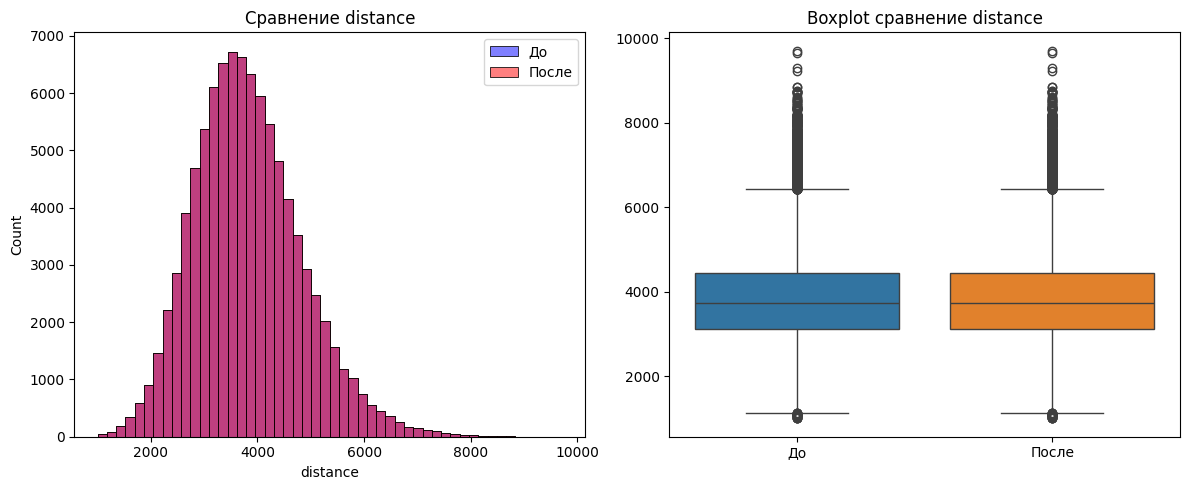

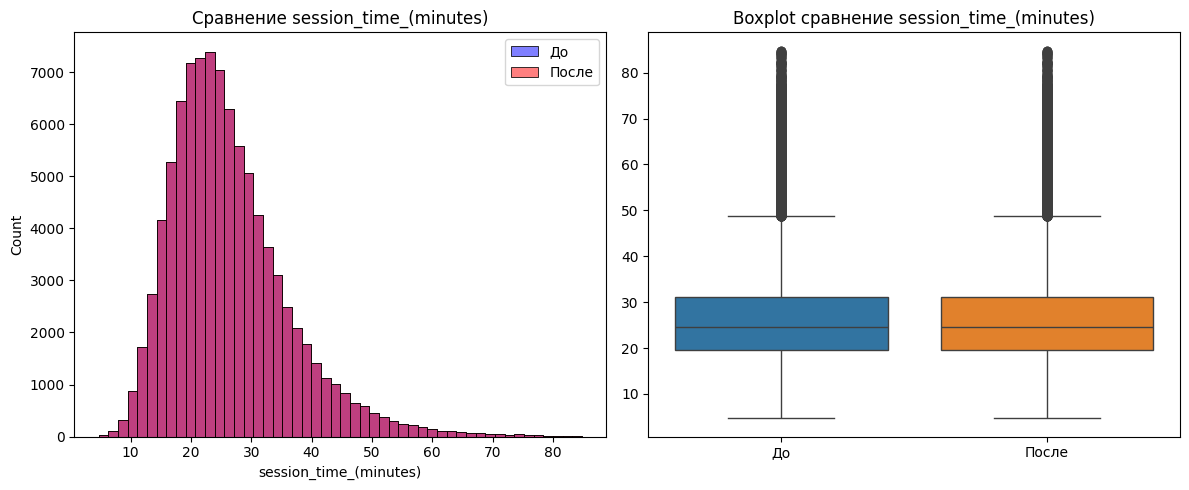

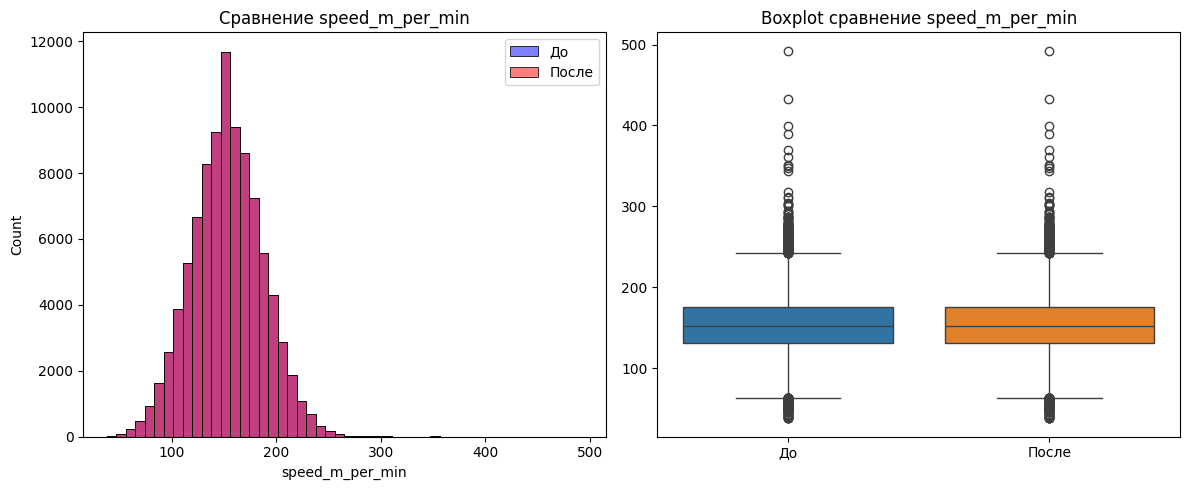

In [211]:
def plot_before_after(original_df, processed_df, column):
    """Сравнение распределений до и после обработки"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(original_df[column], bins=50, color='blue', alpha=0.5, label='До')
    sns.histplot(processed_df[column], bins=50, color='red', alpha=0.5, label='После')
    plt.title(f'Сравнение {column}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pd.DataFrame({
        'До': original_df[column],
        'После': processed_df[column]
    }))
    plt.title(f'Boxplot сравнение {column}')
    
    plt.tight_layout()
    plt.show()

# Сохраняем исходные данные для сравнения
original_df = df.copy()

# Применяем обработку
processed_df = fill_based_on_location(original_df.copy())

# Визуализируем изменения
for col in ['distance', 'session_time_(minutes)', 'speed_m_per_min']:
    plot_before_after(original_df, processed_df, col)

In [212]:
print("Оставшиеся пропуски после обработки:")
print(df.isna().sum()[df.isna().sum() > 0])

# Заполнение оставшихся пропусков
if df.isna().sum().sum() > 0:
    print("\nЗаполняем оставшиеся пропуски медианными значениями...")
    for col in ['distance', 'session_time_(minutes)']:
        df[col] = df[col].fillna(df[col].median())
    
    # Финальная проверка
    print("\nПропуски после финального заполнения:")
    print(df.isna().sum())

Оставшиеся пропуски после обработки:
Series([], dtype: int64)


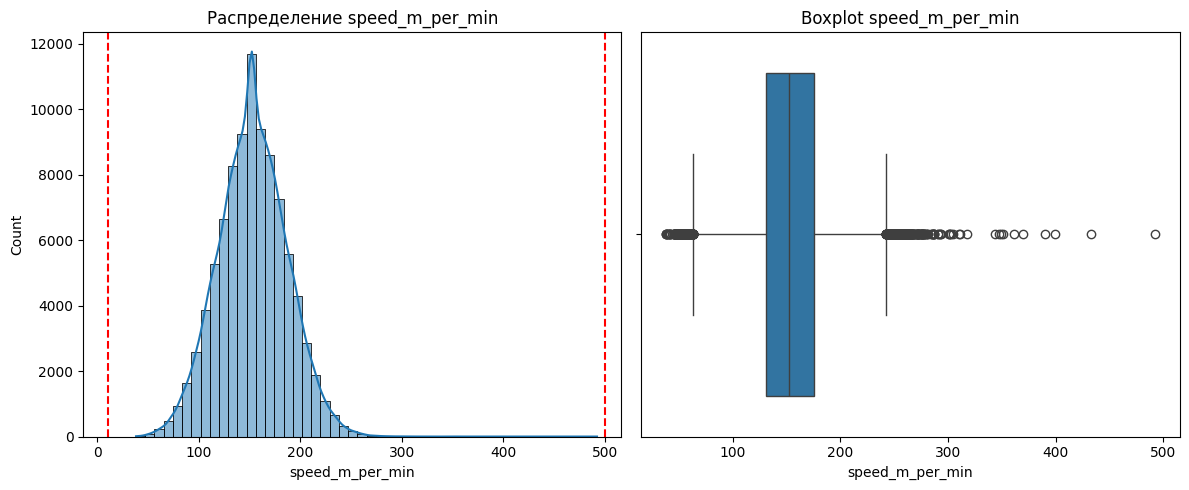


Финальная статистика по промокодам:


distance         session_time_(minutes)        speed_m_per_min  \
              mean  median                   mean median            mean   
promo                                                                      
0      3822.669979  3736.0              26.389055   24.6      153.033977   
1      3775.388949  3686.0              24.703321   23.4      161.114176   

                   
           median  
promo              
0      152.125749  
1      159.550562

In [213]:
# Проверка скорости после всех обработок
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
plot_distribution_with_thresholds(df, 'speed_m_per_min', 10, 500)

# Проверка промокодов
print("\nФинальная статистика по промокодам:")
display(df.groupby('promo').agg({
    'distance': ['mean', 'median'],
    'session_time_(minutes)': ['mean', 'median'],
    'speed_m_per_min': ['mean', 'median']
}))

### <span style="color:#006400">Данные в weather.csv</span>

#### Полные дубликаты и по столбцам

In [214]:
duplicates = df2[df2.duplicated()]
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 0 полных дубликатов


In [215]:
df2.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

#### Посмотрим на неявные дубликаты

Статистика дубликатов:
{'exact_duplicates': 0, 'inconsistent_duplicates': 0}


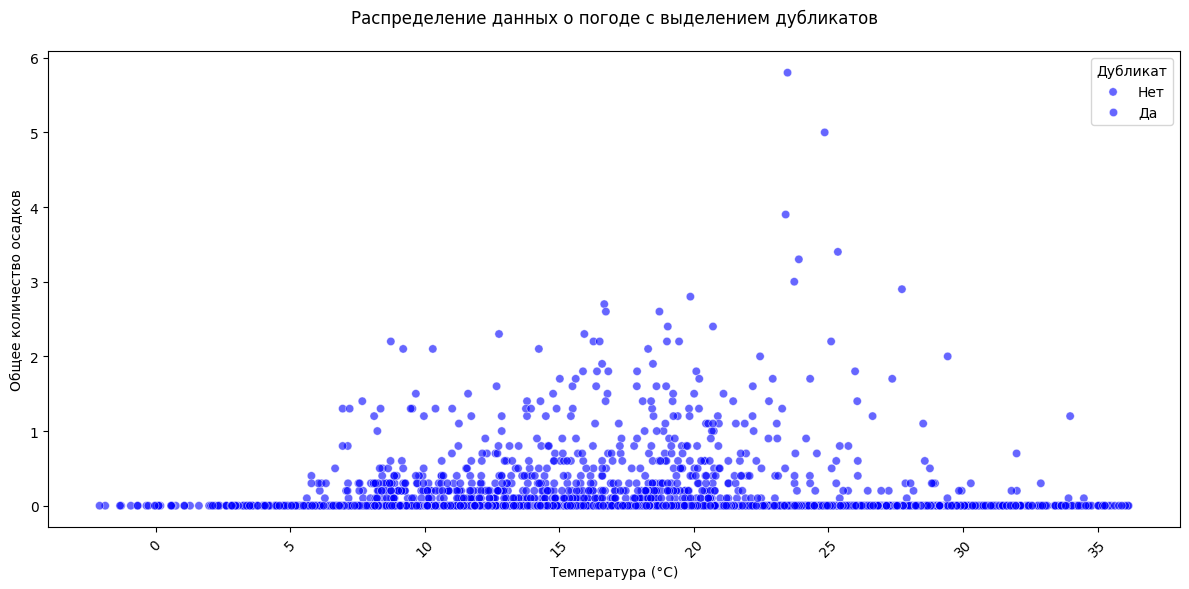

Количество записей после очистки: 3672


In [216]:
def check_all_duplicates_weather(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame с данными о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о погоде
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по всем столбцам
    duplicate_stats = {
        'exact_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['temperature', 'precipitation_total', 
                'wind_gust', 'wind_speed', 'cloud_cover_total', 
                'sunshine_duration']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates_weather(df, duplicates):
    """
    Визуализация результатов проверки дубликатов для данных о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график данных о погоде с выделением дубликатов
    ax = sns.scatterplot(
        x='temperature',
        y='precipitation_total',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение данных о погоде с выделением дубликатов', pad=20)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Общее количество осадков')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates_weather(df, duplicates, strategy='keep_first'):
    """
    Очистка данных о погоде от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")



duplicates, stats = check_all_duplicates_weather(df2)

print("Статистика дубликатов:")
print(stats)

# Визуализация дубликатов
visualize_duplicates_weather(df2, duplicates)

# Очистка данных от дубликатов
df2 = clean_duplicates_weather(df2, duplicates, strategy='keep_first')

print(f"Количество записей после очистки: {len(df2)}")

#### заполнение дубликатов по столбцам

заполнение пропусков в weather 

Пропуски до обработки:
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Анализ пропусков для temperature:
Всего пропусков: 55
Количество последовательностей пропусков: 6

Самые длинные последовательности пропусков:
- 23 пропусков подряд с 2023-08-06 05:00:00 по 2023-08-07 03:00:00
- 10 пропусков подряд с 2023-04-16 02:00:00 по 2023-04-16 11:00:00
- 8 пропусков подряд с 2023-05-12 21:00:00 по 2023-05-13 04:00:00
- 6 пропусков подряд с 2023-07-14 09:00:00 по 2023-07-14 14:00:00
- 5 пропусков подряд с 2023-07-15 00:00:00 по 2023-07-15 04:00:00


C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


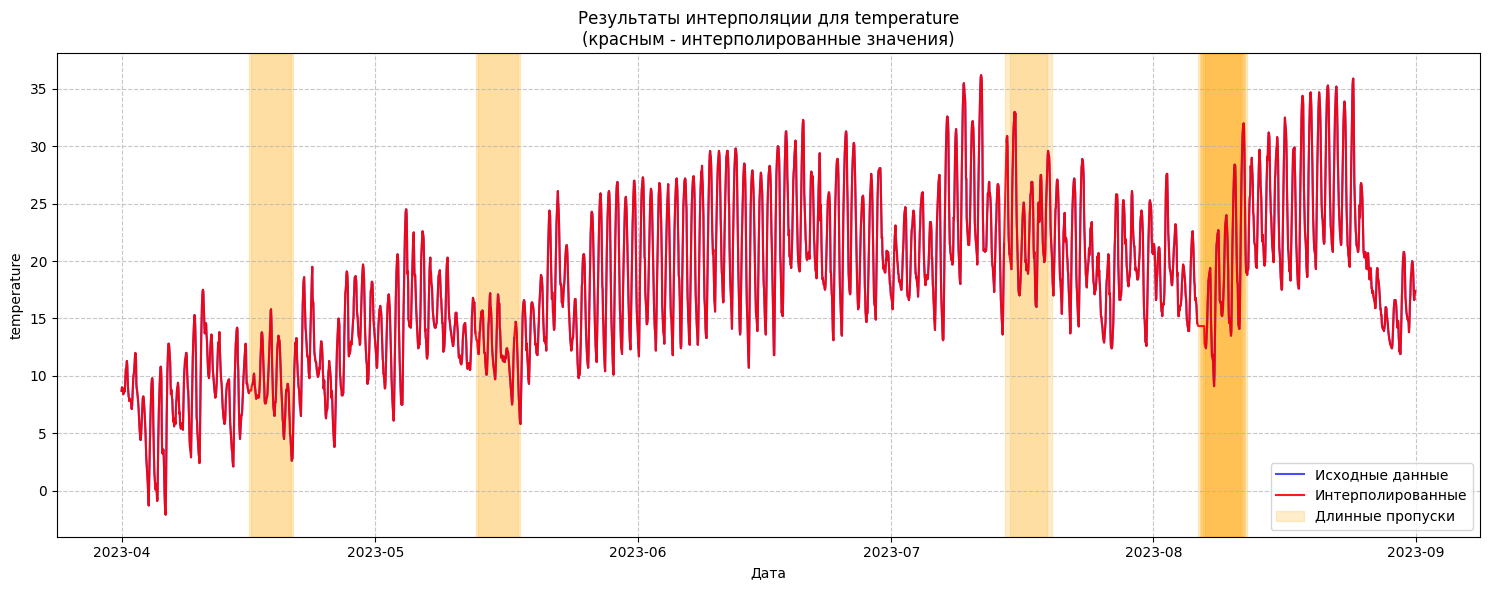


Проверка окрестностей длинных пропусков для temperature:

Окрестности 2023-04-16 02:00:00:
datetime
2023-04-13 02:00:00    6.2
2023-04-13 03:00:00    6.0
2023-04-13 04:00:00    5.8
2023-04-13 05:00:00    5.9
2023-04-13 06:00:00    6.2
                      ... 
2023-04-18 22:00:00    7.8
2023-04-18 23:00:00    7.2
2023-04-19 00:00:00    7.0
2023-04-19 01:00:00    6.6
2023-04-19 02:00:00    6.5
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-04-16 09:00:00:
datetime
2023-04-13 09:00:00     8.6
2023-04-13 10:00:00     8.9
2023-04-13 11:00:00     9.3
2023-04-13 12:00:00     9.3
2023-04-13 13:00:00     9.3
                       ... 
2023-04-19 05:00:00     7.7
2023-04-19 06:00:00     8.2
2023-04-19 07:00:00     9.5
2023-04-19 08:00:00    10.7
2023-04-19 09:00:00    11.7
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-05-13 01:00:00:
datetime
2023-05-10 01:00:00    13.3
2023-05-10 02:00:00    13.0
2023-05-10 03:00:00    13.0
2023-05-10 04:00:00    12.6
20

C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


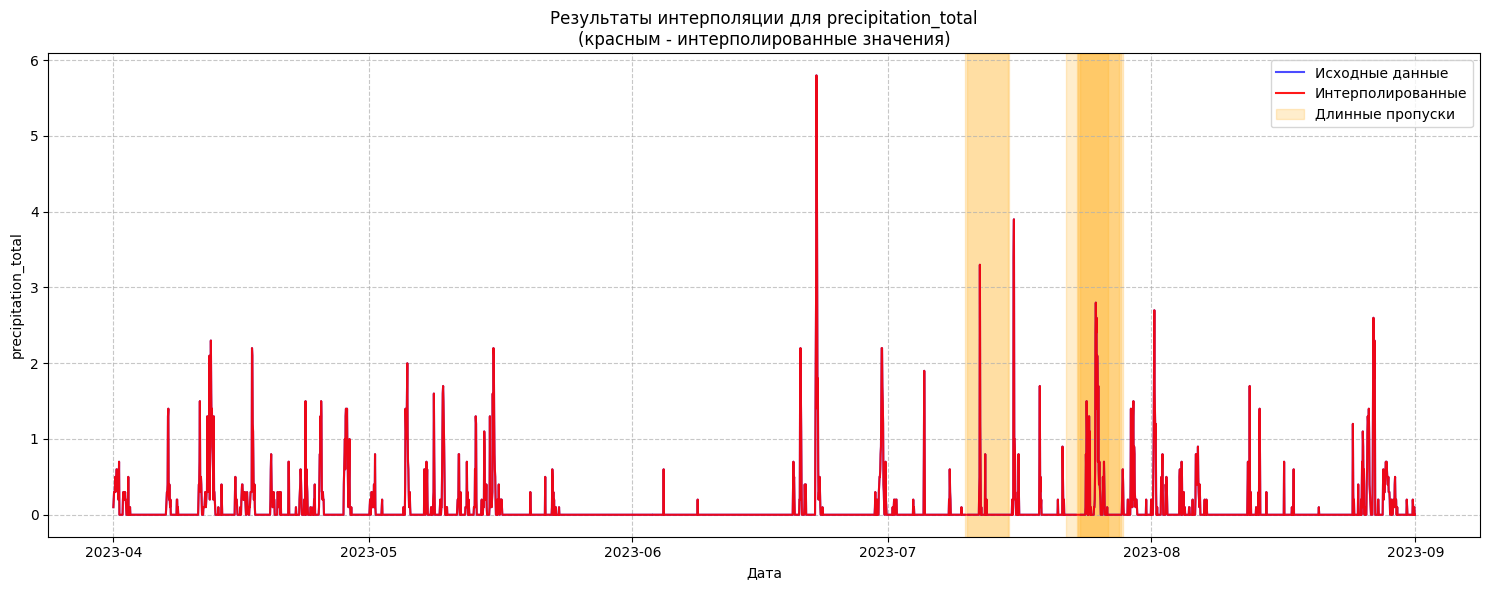


Проверка окрестностей длинных пропусков для precipitation_total:

Окрестности 2023-06-03 08:00:00:
datetime
2023-05-31 08:00:00    0.0
2023-05-31 09:00:00    0.0
2023-05-31 10:00:00    0.0
2023-05-31 11:00:00    0.0
2023-05-31 12:00:00    0.0
                      ... 
2023-06-06 04:00:00    0.0
2023-06-06 05:00:00    0.0
2023-06-06 06:00:00    0.0
2023-06-06 07:00:00    0.0
2023-06-06 08:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-10 06:00:00:
datetime
2023-07-07 06:00:00    0.0
2023-07-07 07:00:00    0.0
2023-07-07 08:00:00    0.0
2023-07-07 09:00:00    0.0
2023-07-07 10:00:00    0.0
                      ... 
2023-07-13 02:00:00    0.0
2023-07-13 03:00:00    0.0
2023-07-13 04:00:00    0.0
2023-07-13 05:00:00    0.0
2023-07-13 06:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-21 23:00:00:
datetime
2023-07-18 23:00:00    0.5
2023-07-19 00:00:00    0.1
2023-07-19 01:00:00    0.2
2023-07-19 02:00:00 

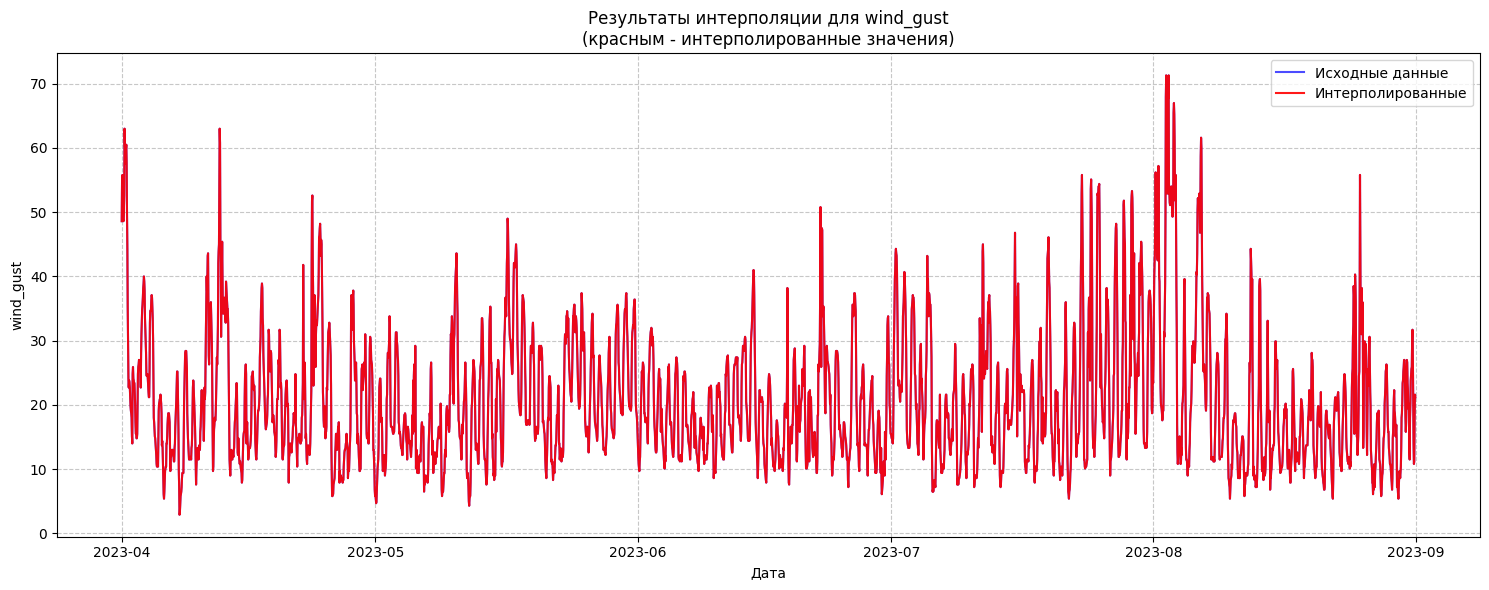


Анализ пропусков для wind_speed:
Всего пропусков: 16
Количество последовательностей пропусков: 4

Самые длинные последовательности пропусков:
- 5 пропусков подряд с 2023-05-24 23:00:00 по 2023-05-25 03:00:00
- 4 пропусков подряд с 2023-05-09 22:00:00 по 2023-05-10 01:00:00
- 4 пропусков подряд с 2023-07-01 00:00:00 по 2023-07-01 03:00:00
- 3 пропусков подряд с 2023-06-20 00:00:00 по 2023-06-20 02:00:00


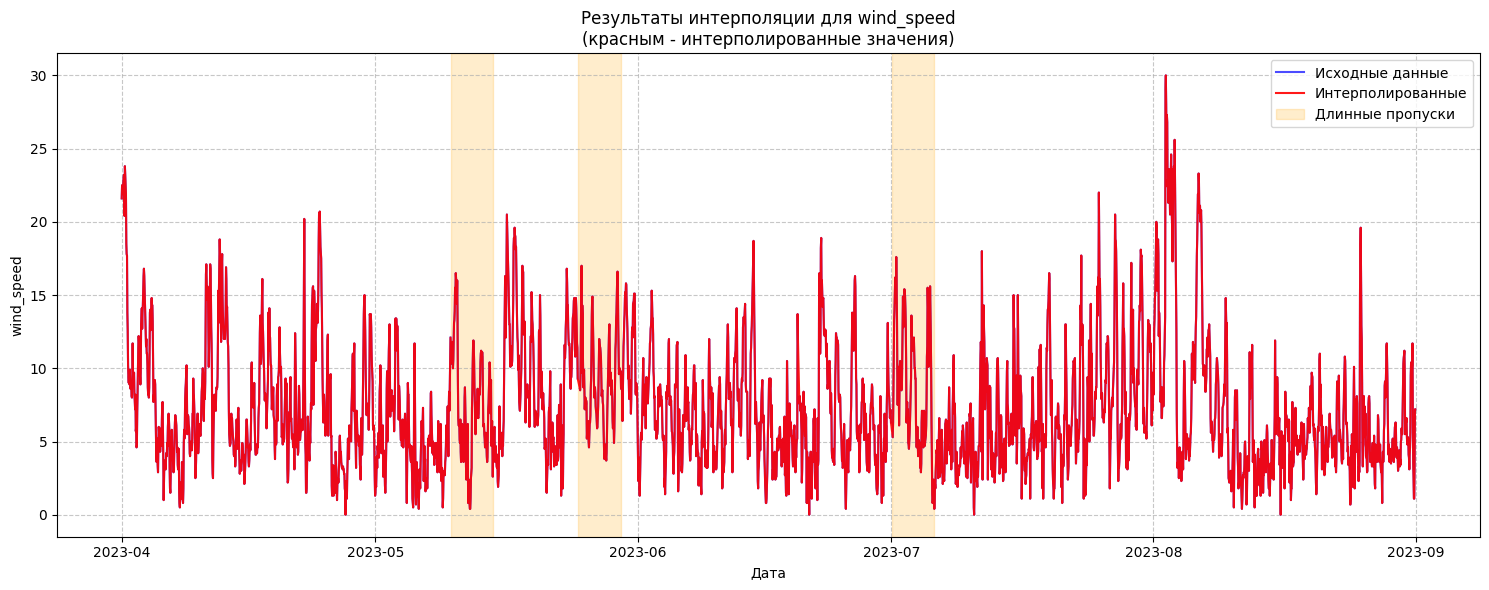


Проверка окрестностей длинных пропусков для wind_speed:

Окрестности 2023-05-09 22:00:00:
datetime
2023-05-06 22:00:00    1.6
2023-05-06 23:00:00    1.8
2023-05-07 00:00:00    2.3
2023-05-07 01:00:00    2.1
2023-05-07 02:00:00    2.5
                      ... 
2023-05-12 18:00:00    8.0
2023-05-12 19:00:00    6.1
2023-05-12 20:00:00    5.5
2023-05-12 21:00:00    6.6
2023-05-12 22:00:00    7.2
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-05-25 02:00:00:
datetime
2023-05-22 02:00:00    4.8
2023-05-22 03:00:00    3.3
2023-05-22 04:00:00    4.0
2023-05-22 05:00:00    4.7
2023-05-22 06:00:00    4.3
                      ... 
2023-05-27 22:00:00    7.5
2023-05-27 23:00:00    6.3
2023-05-28 00:00:00    5.4
2023-05-28 01:00:00    4.2
2023-05-28 02:00:00    3.8
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-07-01 02:00:00:
datetime
2023-06-28 02:00:00    3.6
2023-06-28 03:00:00    3.3
2023-06-28 04:00:00    3.0
2023-06-28 05:00:00    3.1
2023-06-28 06:00:00 

C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\595835855.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


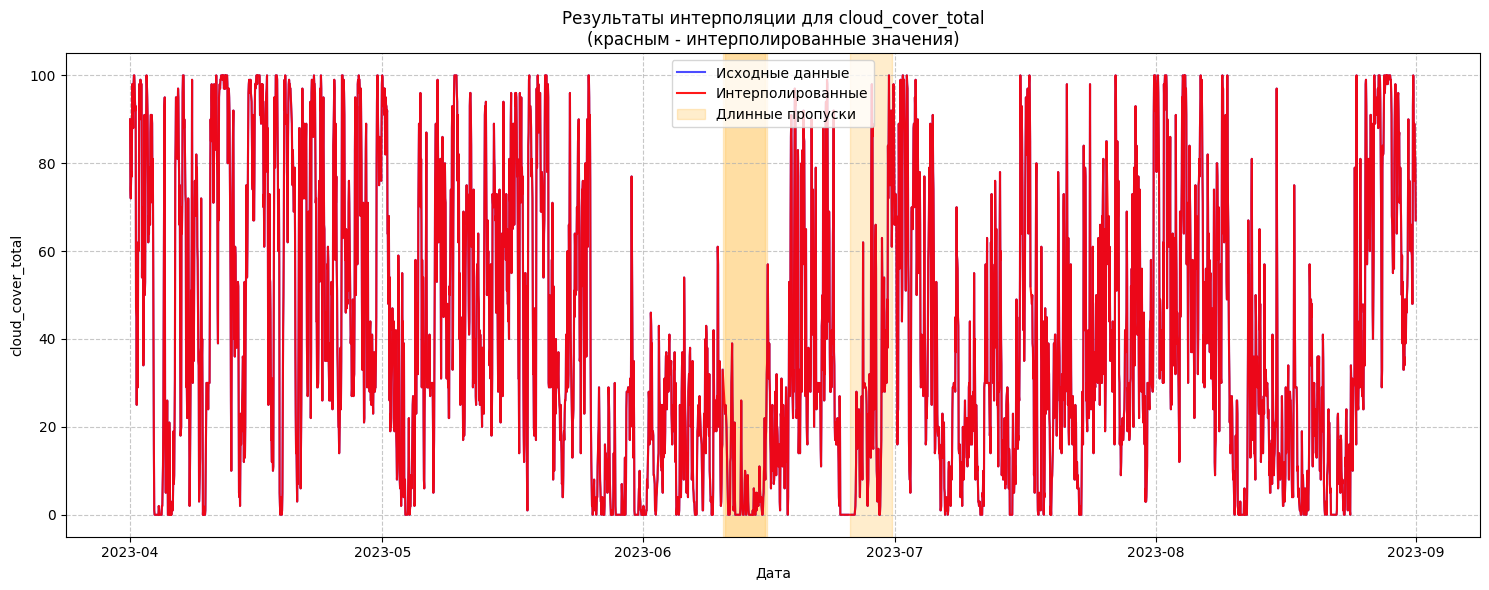


Проверка окрестностей длинных пропусков для cloud_cover_total:

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    20.0
2023-06-07 14:00:00    24.0
2023-06-07 15:00:00    25.0
2023-06-07 16:00:00    18.0
2023-06-07 17:00:00    25.0
                       ... 
2023-06-13 09:00:00     3.0
2023-06-13 10:00:00     8.0
2023-06-13 11:00:00     9.0
2023-06-13 12:00:00     9.0
2023-06-13 13:00:00     3.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-06-25 13:00:00:
datetime
2023-06-22 13:00:00    69.0
2023-06-22 14:00:00    26.0
2023-06-22 15:00:00    35.0
2023-06-22 16:00:00    32.0
2023-06-22 17:00:00    62.0
                       ... 
2023-06-28 09:00:00    16.0
2023-06-28 10:00:00    15.0
2023-06-28 11:00:00    23.0
2023-06-28 12:00:00    53.0
2023-06-28 13:00:00    24.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-07-17 04:00:00:
datetime
2023-07-14 04:00:00    19.0
2023-07-14 05:00:00     7.0
2023-07-14 06:00:00    25.0
2

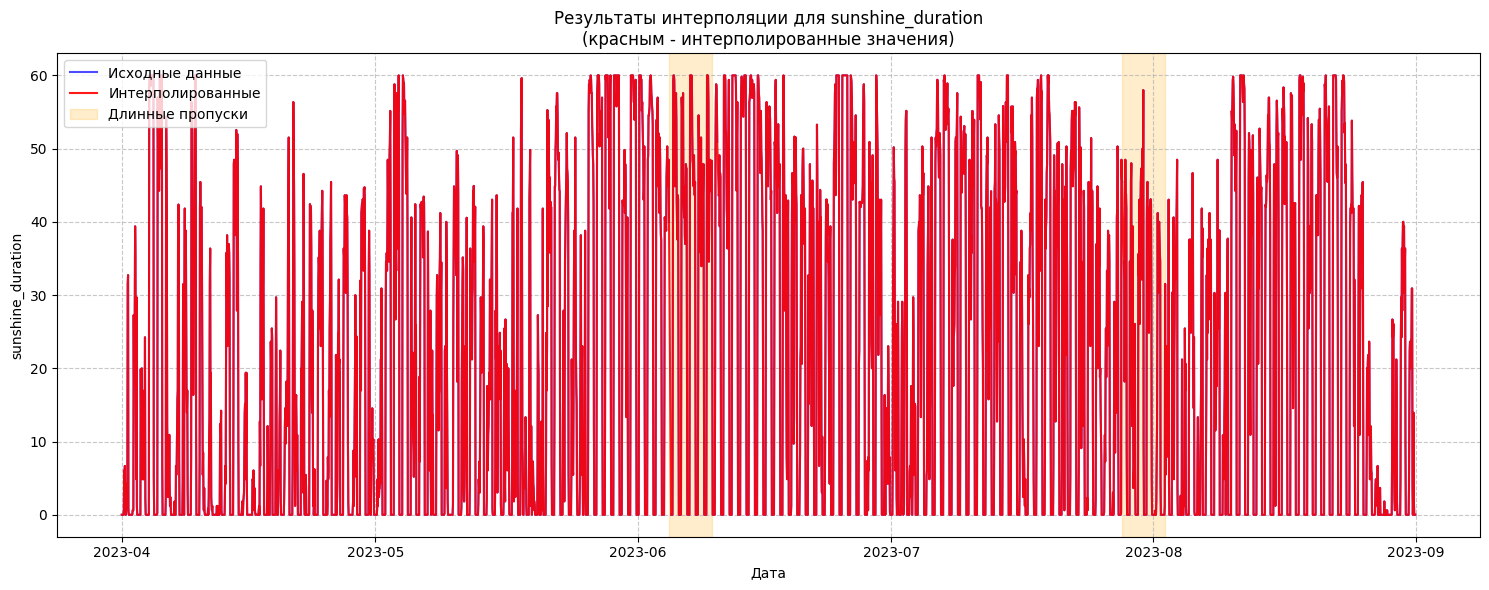


Проверка окрестностей длинных пропусков для sunshine_duration:

Окрестности 2023-06-04 18:00:00:
datetime
2023-06-01 18:00:00    44.24
2023-06-01 19:00:00    50.30
2023-06-01 20:00:00    17.46
2023-06-01 21:00:00     0.00
2023-06-01 22:00:00     0.00
                       ...  
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
2023-06-07 18:00:00    43.64
Name: sunshine_duration, Length: 145, dtype: float64

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    47.88
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
                       ...  
2023-06-13 09:00:00    58.00
2023-06-13 10:00:00    55.09
2023-06-13 11:00:00    54.55
2023-06-13 12:00:00    54.36
2023-06-13 13:00:00    58.00
Name: sunshine_duration, Length: 145, dtype: float64

Пропуски после обработки:
temperature            0
precipitation_total    0
wind_gust              0
wind

In [217]:
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2['datetime'] = pd.to_datetime(df2['datetime'])
numeric_cols = ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 
               'cloud_cover_total', 'sunshine_duration']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')
df2.set_index('datetime', inplace=True)

# Функция для анализа последовательных пропусков
def analyze_missing_sequences(series, max_gap_to_show=5):
    """Анализирует последовательности пропущенных значений"""
    is_null = series.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    null_sequences = series.groupby(null_groups).apply(lambda x: (x.isnull().all(), len(x)))
    
    long_sequences = [(i, length) for i, (is_null, length) in null_sequences.items() if is_null and length > 1]
    
    print(f"\nАнализ пропусков для {series.name}:")
    print(f"Всего пропусков: {is_null.sum()}")
    print(f"Количество последовательностей пропусков: {len(long_sequences)}")
    
    if long_sequences:
        print("\nСамые длинные последовательности пропусков:")
        for seq_id, length in sorted(long_sequences, key=lambda x: -x[1])[:max_gap_to_show]:
            start_idx = null_groups[null_groups == seq_id].index[0]
            end_idx = null_groups[null_groups == seq_id].index[-1]
            print(f"- {length} пропусков подряд с {start_idx} по {end_idx}")

# Функция для интеллектуальной интерполяции
def smart_interpolate(series, max_gap=3, method='time'):
    """Интерполяция с учетом максимально допустимого промежутка"""
    # Анализ пропусков перед интерполяцией
    analyze_missing_sequences(series)
    
    # Интерполяция с ограничением на длину промежутка
    interpolated = series.interpolate(method=method, limit=max_gap, limit_direction='both')
    
    # Для оставшихся пропусков используем заполнение вперед/назад
    if interpolated.isna().any():
        interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')
    
    return interpolated

# Улучшенная функция визуализации
def plot_interpolation_results(original, interpolated, window=5):
    """Визуализация результатов интерполяции с акцентом на проблемные зоны"""
    plt.figure(figsize=(15, 6))
    
    # Находим проблемные зоны (где были длинные пропуски)
    is_null = original.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    long_gaps = original.groupby(null_groups).filter(lambda x: x.isnull().sum() > 3)
    
    # Основной график
    plt.plot(original.index, original, color='blue', label='Исходные данные', alpha=0.7)
    plt.plot(interpolated.index, interpolated, color='red', label='Интерполированные', alpha=0.9)
    
    # Выделяем проблемные зоны
    if not long_gaps.empty:
        for gap_start in long_gaps.index[::window]:
            gap_end = min(gap_start + pd.Timedelta(days=window), original.index[-1])
            plt.axvspan(gap_start, gap_end, color='orange', alpha=0.2, label='Длинные пропуски')
    
    # Настройки графика
    plt.title(f'Результаты интерполяции для {original.name}\n(красным - интерполированные значения)')
    plt.xlabel('Дата')
    plt.ylabel(original.name)
    
    # Упрощаем легенду
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Применяем улучшенную интерполяцию
print("Пропуски до обработки:")
print(df2[numeric_cols].isna().sum())

for col in numeric_cols:
    original = df2[col].copy()
    df2[col] = smart_interpolate(original, max_gap=3)
    plot_interpolation_results(original, df2[col])
    
    # Дополнительная проверка для длинных пропусков
    if original.isnull().any():
        print(f"\nПроверка окрестностей длинных пропусков для {col}:")
        null_periods = original[original.isnull()].index
        for period in null_periods[::7]:  # Проверяем каждую неделю пропусков
            start = period - pd.Timedelta(days=3)
            end = period + pd.Timedelta(days=3)
            window_data = df2.loc[start:end, col]
            print(f"\nОкрестности {period}:")
            print(window_data)

print("\nПропуски после обработки:")
print(df2[numeric_cols].isna().sum())
assert df2[numeric_cols].isna().sum().sum() == 0, "Остались незаполненные значения!"

## <span style="color:#00008B">Поверхностный анализ под конец</span>

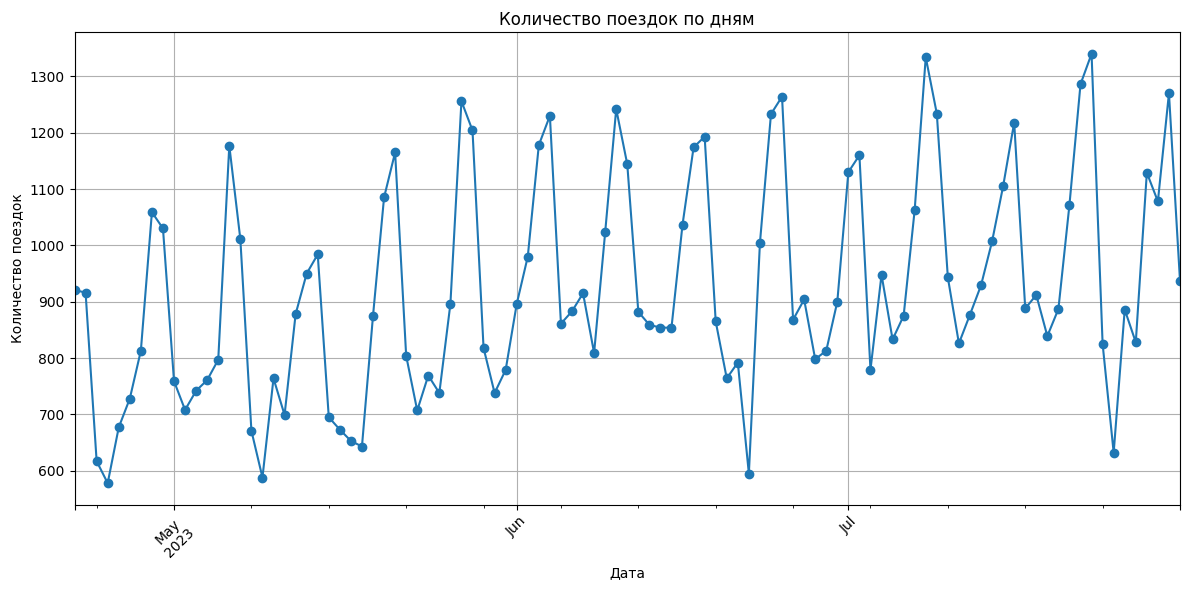

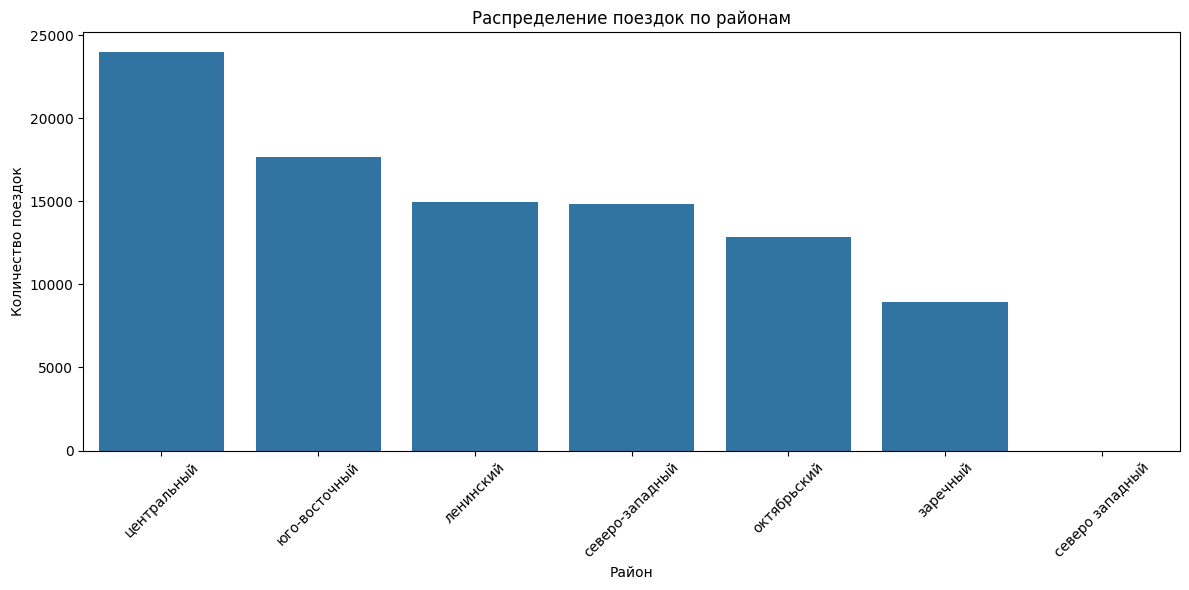

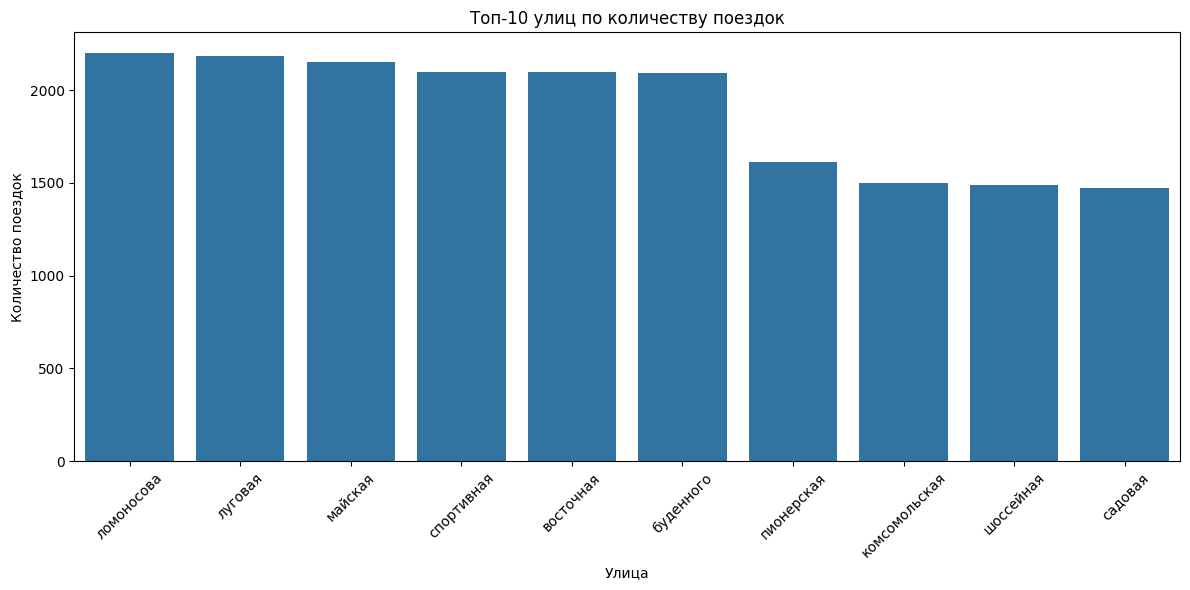

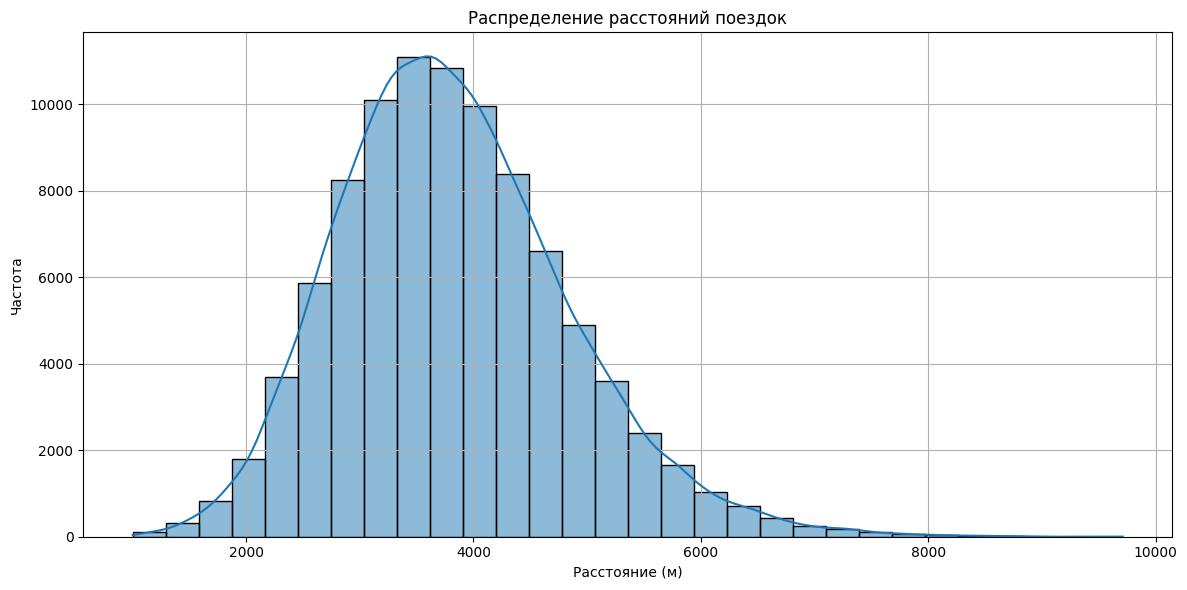

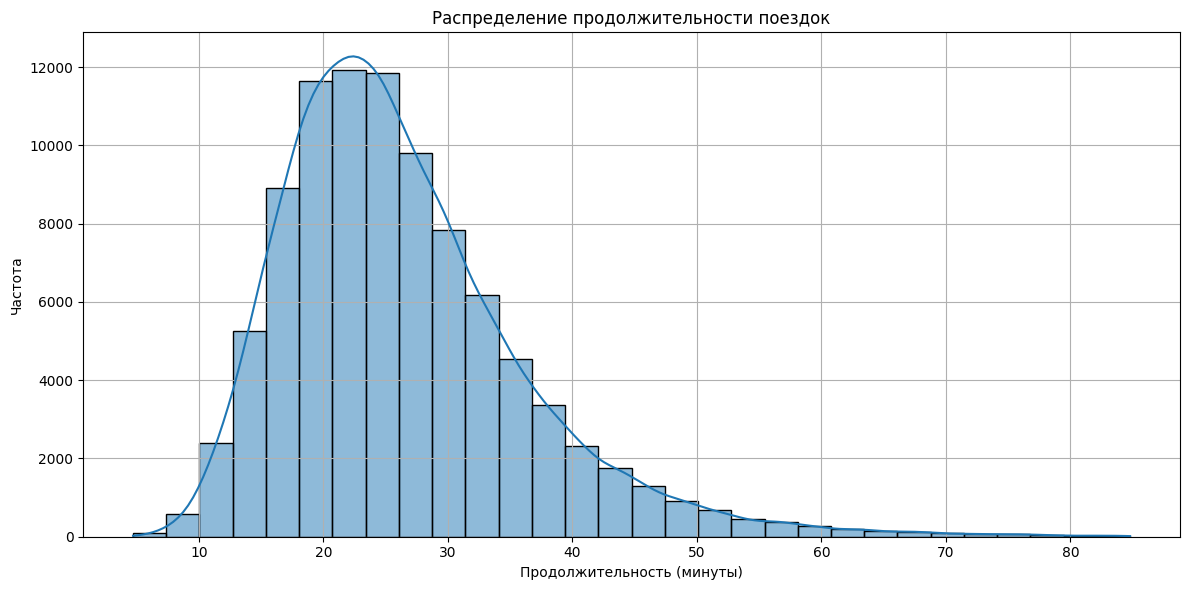

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 93210 entries, 0 to 102254
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      93210 non-null  int64         
 1   start_date              93210 non-null  datetime64[ns]
 2   end_date                93210 non-null  datetime64[ns]
 3   start_location          93210 non-null  object        
 4   start_district          93210 non-null  object        
 5   end_location            93210 non-null  object        
 6   end_district            93210 non-null  object        
 7   distance                93210 non-null  float64       
 8   promo                   93210 non-null  int64         
 9   session_time            93210 non-null  object        
 10  session_time_(minutes)  93210 non-null  float64       
 11  is_duplicate            93210 non-null  bool          
 12  speed_m_per_min        

In [218]:
df['start_date'] = pd.to_datetime(df['start_date'])

# 1. Анализ количества поездок по дням
daily_rides = df.resample('D', on='start_date').size()

plt.figure(figsize=(12, 6))
daily_rides.plot(kind='line', marker='o')
plt.title('Количество поездок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Распределение поездок по районам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_district', order=df['start_district'].value_counts().index)
plt.title('Распределение поездок по районам')
plt.xlabel('Район')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Распределение поездок по улицам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_location', order=df['start_location'].value_counts().head(10).index)
plt.title('Топ-10 улиц по количеству поездок')
plt.xlabel('Улица')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Анализ расстояния поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['distance'], bins=30, kde=True)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 5. Анализ продолжительности поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['session_time_(minutes)'], bins=30, kde=True)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минуты)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 6. Общая информация о данных
print("Общая информация о данных:")
print(df.info())
print("\nСтатистические характеристики:")
print(df.describe())

## <span style="color:#00008B">Дополнительные материалы </span>

Ура тут пусто 

## <span style="color:#00008B">Y-data profiling </span>

In [219]:
profile=ProfileReport(df, title = "Profiling Report", correlations={
"auto": {"calculate": False},
"pearson": {"calculate": True},
"spearman": {"calculate": True},
"phi_k": {"calculate": True},
"cramers": {"calculate": True},})

In [220]:
profile

ModuleNotFoundError: No module named 'ipywidgets'

In [221]:
profile=ProfileReport(df2, title = "Profiling Report", correlations={
"auto": {"calculate": False},
"pearson": {"calculate": True},
"spearman": {"calculate": True},
"phi_k": {"calculate": True},
"cramers": {"calculate": True},})

In [222]:
profile

ModuleNotFoundError: No module named 'ipywidgets'

# Общий вывод по проделанной работе на спринт с 01 по 06 апреля
Проведен детальный анализ двух датасетов:  
- rides.csv (данные о поездках):  
  - Обнаружены аномалии в дистанции (Distance) и времени сессии (Session Time).  
  - Выявлены полные дубликаты (4,831) и пропуски (555) в датах окончания поездок.  
  - Категориальные признаки (районы, локации) требуют стандартизации.  
- weather.csv (погодные данные):  
  - Данные хранятся в неоптимальном формате (единицы измерения в ячейках, строковые числа).
  - Проведена очистка и преобразование типов.
  - Проведено заполение пропусков путём интерполяции

Работа сделала основу для дальнейшего углубленного исследования. 🚀

# <span style="color:#8B0000">Спринт 2 - Проведение расчетов и исследований/проверка гепотиз</span>

## <span style="color:#00008B">Расчет итоговой стоимости и оценка эффективности акции</span>

**Рассчитать итоговую стоимость.**
Проверить, стимулирует ли акция спрос на самокаты (учесть сопоставимость дней). Окупается
ли она (сравнить прибыль с издержками проведения).

In [223]:
df.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,session_time,session_time_(minutes),is_duplicate,speed_m_per_min,route
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,0,00:23:42,23.7,False,171.687764,шевченко->майская
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,00:28:25,28.4,False,158.978873,чехова->спортивная
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,00:38:19,38.3,False,118.015666,буденного->суворова
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,0,00:31:49,31.8,False,122.044025,труда->рабочая
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,0,00:30:40,30.7,False,131.237785,первомайская->юбилейная


**Считаем в общем**

In [224]:
def calculate_cost(row):
    # Получаем длительность поездки в минутах
    duration = row['session_time_(minutes)']
    start_date = pd.to_datetime(row['start_date'])
    hour = start_date.hour
    weekday = start_date.weekday()
    weekend = weekday >= 5  # Суббота и воскресенье

    # Определяем тариф
    if not weekend:
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 5
        elif 16 <= hour < 22:
            rate = 6
        else:  # 22:00 - 01:00
            rate = 5
    else:  # Если выходной
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 6
        elif 16 <= hour < 22:
            rate = 7
        else:  # 22:00 - 01:00
            rate = 6

    # Проверяем условие акции "Бесплатный старт"
    free_start = weekday == 0 and 6 <= hour < 10 and row['promo'] == 1
    start_cost = 0 if free_start else 30

    # Рассчитываем итоговую стоимость
    return round(start_cost + duration * rate, 2)

# Применение функции к DataFrame
df['cost'] = df.apply(calculate_cost, axis=1)

# Выводим нужные столбцы
print(df[['id', 'start_date', 'session_time_(minutes)', 'cost']])

            id          start_date  session_time_(minutes)   cost
0       100340 2023-04-22 09:01:03                    23.7  124.8
1       100341 2023-04-22 09:01:07                    28.4  143.6
2       100342 2023-04-22 09:04:27                    38.3  183.2
3       100343 2023-04-22 09:06:34                    31.8  157.2
4       100344 2023-04-22 09:09:27                    30.7  152.8
...        ...                 ...                     ...    ...
102250  197707 2023-07-31 23:45:06                    21.8  139.0
102251  197708 2023-07-31 23:46:01                    39.6  228.0
102252  197709 2023-07-31 23:48:04                    21.3  136.5
102253  197710 2023-07-31 23:51:41                    46.4  262.0
102254  197711 2023-07-31 23:57:01                    22.0  140.0

[93210 rows x 4 columns]


In [225]:
# df['start_date'] = pd.to_datetime(df['start_date'])

# def calculate_cost(row):
#     start_time = row['start_date']
#     duration = (pd.to_datetime(row['end_date']) - start_time).total_seconds() / 60
#     is_monday = start_time.weekday() == 0
#     hour = start_time.hour
#     promo_applied = row['promo'] == 1
#     start_cost = 0 if (is_monday and 6 <= hour < 10 and promo_applied) else 30
#     minute_cost = 4 if start_time.weekday() < 5 else 4
#     return start_cost + duration * minute_cost

# df['cost'] = df.apply(calculate_cost, axis=1)
promo_rides = df[df['start_date'].dt.weekday == 0]
non_promo_rides = df[df['start_date'].dt.weekday != 0]
p_rides = len(promo_rides)
np_rides = len(non_promo_rides)
p_rev = promo_rides['cost'].sum()
np_rev = non_promo_rides['cost'].sum()

print(f"Акционные поездки: {p_rides} поездок")
print(f"Неакционные поездки: {np_rides} поездок")
print(f"Акционная выручка: {p_rev:.2f} руб.")
print(f"Неакционная выручка: {np_rev:.2f} руб.")

avg_p_cost = p_rev / p_rides if p_rides > 0 else 0
avg_np_cost = np_rev / np_rides if np_rides > 0 else 0

print(f"Средняя стоимость акционной поездки: {avg_p_cost:.2f} руб.")
print(f"Средняя стоимость неакционной поездки: {avg_np_cost:.2f} руб.")

promo_cost = p_rides * 5
print(f"Затраты на акцию: {promo_cost:.2f} руб.")

profit_diff = p_rev - promo_cost - np_rev
print(f"Итог: {round(profit_diff)} руб.")

Акционные поездки: 12212 поездок
Неакционные поездки: 80998 поездок
Акционная выручка: 1939333.10 руб.
Неакционная выручка: 14689525.40 руб.
Средняя стоимость акционной поездки: 158.81 руб.
Средняя стоимость неакционной поездки: 181.36 руб.
Затраты на акцию: 61060.00 руб.
Итог: -12811252 руб.


**Считаем в среднем**

In [226]:
# df['start_date'] = pd.to_datetime(df['start_date']).dt.date
# # df['cost'] = df['distance'] * 5 / 1000

# daily_stats = df.groupby('start_date').agg(
#     Total_Rides=('id', 'count'),
#     Total_Distance=('distance', 'sum'),
#     Total_Revenue=('cost', 'sum'),
#     Promo_Day=('promo', 'max')
# ).reset_index()

# p_avg = daily_stats[daily_stats['Promo_Day'] == 1].mean(numeric_only=True)
# np_avg = daily_stats[daily_stats['Promo_Day'] == 0].mean(numeric_only=True)

# print(f"Среднее количество поездок в день с акцией: {p_avg['Total_Rides']:.0f}")
# print(f"Среднее количество поездок в день без акции: {np_avg['Total_Rides']:.0f}")
# rides_diff = p_avg['Total_Rides'] - np_avg['Total_Rides']
# rides_percent_diff = (p_avg['Total_Rides']/np_avg['Total_Rides']-1)*100 if np_avg['Total_Rides'] != 0 else 0
# print(f"Разница: {rides_diff:.0f} поездок (+{rides_percent_diff:.1f}%)")

# print(f"\nСредняя выручка в день с акцией: {p_avg['Total_Revenue']:.2f} руб.")
# print(f"Средняя выручка в день без акции: {np_avg['Total_Revenue']:.2f} руб.")
# revenue_diff = p_avg['Total_Revenue'] - np_avg['Total_Revenue']
# print(f"Разница: {revenue_diff:.2f} руб.")

## <span style="color:#00008B">Анализ точек</span>

**Подготовить таблицу с почасовым трафиком в каждой точке**
* Определить топ-3 точки с самым высоким трафиком. Есть ли точки, которые можно закрыть?
Какие самые популярные направления перемещения? Есть ли необходимость в конце дня
перераспределять самокаты по точкам.
* Изучить накопительное поведение разницы в трафике в каждой точке (cumsum). Определить
необходимое количество самокатов в каждой точке и в каждом районе для удовлетворения
спроса в полном объеме. (Предполагаем, что ежедневно в 6:00 самокаты
перераспределяются к исходной позиции)

In [227]:
#Подготовка таблицы с почасовым трафиком в каждой точке
df['start_hour'] = pd.to_datetime(df['start_date']).dt.hour

# Группируем по start_location и start_hour, считаем количество поездок
hourly_traffic = df.groupby(['start_location', 'start_hour']).size().unstack(fill_value=0)

# Выводим таблицу
print("Почасовой трафик по точкам:")
print(hourly_traffic)

Почасовой трафик по точкам:
start_hour      0   1   2   3   4   5   6   7    8   9   ...   14   15   16  \
start_location                                           ...                  
береговая       11   7   3   2   4   2  14  20   25  33  ...   50   40   57   
березовая       12   5   5   5   0  12  35  49   50  46  ...   52   68   86   
буденного       28  12   4   5   4  20  75  80  112  95  ...  121  125  145   
вишневая         7   3   1   1   2   9  13  26   45  31  ...   43   55   77   
вокзальная      13   3   2   1   1  10  15  33   37  25  ...   54   53   50   
...             ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ...  ...  ...  ...   
шоссейная       12   7   4   4   0   9  44  52   79  67  ...   80   80  115   
энергетиков      3   6   7   3   1  13  24  31   38  30  ...   40   40   51   
энтузиастов      8   9   2   0   1   7  13  20   29  27  ...   35   44   68   
юбилейная       10  12   3   1   1  10  22  31   35  27  ...   41   54   50   
южная            9   4  

In [228]:
#Топ-3 точки с самым высоким трафиком
# Суммируем поездки по точкам
total_traffic = hourly_traffic.sum(axis=1).sort_values(ascending=False)

# Топ-3 точки
top_3_locations = total_traffic.head(3)
print("\nТоп-3 точки с самым высоким трафиком:")
print(top_3_locations)


Топ-3 точки с самым высоким трафиком:
start_location
ломоносова    2202
луговая       2186
майская       2151
dtype: int64


In [229]:
#Точки, которые можно закрыть
low_traffic_locations = total_traffic[total_traffic < 800]
print("\nТочки с низким трафиком (кандидаты на закрытие):")
print(low_traffic_locations)


Точки с низким трафиком (кандидаты на закрытие):
start_location
куйбышева          799
маяковского        799
пушкина            798
строителей         797
шевченко           796
горького           795
железнодорожная    795
гагарина           794
вокзальная         793
дзержинского       792
энергетиков        792
коммунальная       792
лесная             787
степная            786
кооперативная      786
речная             786
юбилейная          784
советская          782
солнечная          781
молодежная         777
матросова          773
дружбы             769
набережная         767
совхозная          766
гоголя             764
сиреневая          762
энтузиастов        757
мира               739
dtype: int64


In [230]:
#Популярные направления перемещения
# Группируем по start_location и end_location, считаем количество поездок
popular_routes = df.groupby(['start_location', 'end_location']).size().sort_values(ascending=False)

# Топ-5 популярных маршрутов
top_5_routes = popular_routes.head(5)
print("\nТоп-5 популярных маршрутов:")
print(top_5_routes)


Топ-5 популярных маршрутов:
start_location  end_location
луговая         спортивная      66
буденного       буденного       64
майская         спортивная      60
спортивная      восточная       58
восточная       луговая         57
dtype: int64


In [231]:
#Необходимость перераспределения самокатов
# Разница между окончанием и началом поездок в каждой точке
end_counts = df['end_location'].value_counts()
start_counts = df['start_location'].value_counts()
balance = end_counts - start_counts

# Точки с наибольшим дисбалансом (требуют перераспределения)
print("\nБаланс самокатов (конец - начало):")
print(balance.sort_values(ascending=False))


Баланс самокатов (конец - начало):
спортивная    128
восточная      85
буденного      83
ленина         83
матросова      83
             ... 
колхозная     -72
дачная        -73
труда         -75
пушкина      -114
пионерская   -196
Name: count, Length: 91, dtype: int64


In [232]:
#Накопительное поведение трафика (cumsum)
# Создаем временную метку для каждой поездки
df['timestamp'] = pd.to_datetime(df['start_date'])

# Сортируем данные по времени
df_sorted = df.sort_values('timestamp')

# Кумулятивная сумма поездок по точкам
df_sorted['cumulative_start'] = df_sorted.groupby('start_location').cumcount() + 1
df_sorted['cumulative_end'] = df_sorted.groupby('end_location').cumcount() + 1

# Разница между окончанием и началом (кумулятивная)
df_sorted['cumulative_balance'] = df_sorted['cumulative_end'] - df_sorted['cumulative_start']

# Анализ по районам
df_sorted['cumulative_start_district'] = df_sorted.groupby('start_district').cumcount() + 1
df_sorted['cumulative_end_district'] = df_sorted.groupby('end_district').cumcount() + 1
df_sorted['cumulative_balance_district'] = df_sorted['cumulative_end_district'] - df_sorted['cumulative_start_district']

# Вывод результатов для точек
print("\nКумулятивный баланс самокатов по точкам:")
print(df_sorted.groupby('start_location')['cumulative_balance'].last().sort_values(ascending=False))

# Вывод результатов для районов
print("\nКумулятивный баланс самокатов по районам:")
print(df_sorted.groupby('start_district')['cumulative_balance_district'].last().sort_values(ascending=False))


Кумулятивный баланс самокатов по точкам:
start_location
сосновая        1376
пролетарская    1371
советская       1371
шевченко        1343
свободы         1190
                ... 
спортивная      -920
буденного      -1298
ломоносова     -1359
майская        -1375
луговая        -1404
Name: cumulative_balance, Length: 91, dtype: int64

Кумулятивный баланс самокатов по районам:
start_district
заречный           9085
ленинский          8523
юго-восточный      5769
северо западный    4681
северо-западный    3191
октябрьский        2196
центральный       -9041
Name: cumulative_balance_district, dtype: int64


**Исследовать корреляцию между параметрами погодных условий. Для наиболее сильных
корреляций обосновать, имеет ли это реальный смысл или же просто особенность данных.**

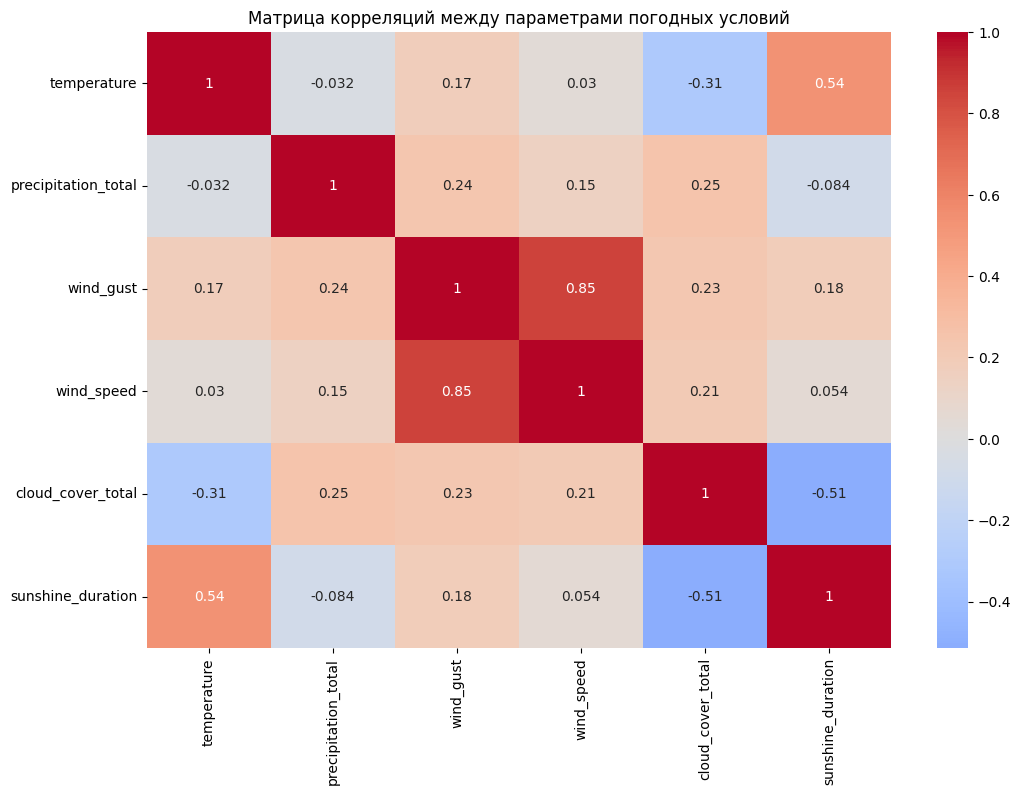

In [233]:
correlation_matrix = df2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций между параметрами погодных условий')
plt.show()

In [234]:
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

# Проверка добавленного столбца
print(df2[['season']].head())

                     season
datetime                   
2023-04-01 00:00:00  Spring
2023-04-01 01:00:00  Spring
2023-04-01 02:00:00  Spring
2023-04-01 03:00:00  Spring
2023-04-01 04:00:00  Spring


In [235]:
# Проверка структуры DataFrame
print(df2.head())
print(df2.info())

# 1. Разделение данных по сезонам
# Используем индекс для получения месяца
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

# Проверка добавленного столбца
print(df2[['season']].head())

# 2. Множественная регрессия
# Модель: Sunshine Duration ~ Temperature + Cloud Cover Total + Wind Speed + Precipitation Total
X = df2[['temperature', 'cloud_cover_total', 'wind_speed', 'precipitation_total']]
y = df2['sunshine_duration']

# Добавление константы для свободного члена
X = sm.add_constant(X)

# Построение модели
model = sm.OLS(y, X).fit()

# Вывод результатов
print(model.summary())

                     temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  
datetime                                                           
2023-04-01 00:00:00               90.0                0.0  Spring  
2023-04-01 01:00:00               74.0                0.0  Spring  
2023-04-01 02:00:00               72.0                0.0  Spring  
2023-04-01 03:00:00               77.0                0.0  Spring  
2023-04-01 04:00:00            

In [236]:
# 3. Проверка временных задержек
# Создание временных задержек для облачности
df2['cloud_cover_total_lag1'] = df2['cloud_cover_total'].shift(1)  # Задержка на 1 час
df2['cloud_cover_total_lag2'] = df2['cloud_cover_total'].shift(2)  # Задержка на 2 часа

# Модель с задержками
X_lagged = df2[['temperature', 'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'wind_speed', 'precipitation_total']]
y_lagged = df2['sunshine_duration']

# Удаление NaN значений после создания задержек
X_lagged = X_lagged.dropna()
y_lagged = y_lagged[X_lagged.index]

# Добавление константы для свободного члена
X_lagged = sm.add_constant(X_lagged)

# Построение модели с задержками
model_lagged = sm.OLS(y_lagged, X_lagged).fit()

# Вывод результатов
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:      sunshine_duration   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     473.1
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:34:27   Log-Likelihood:                -15618.
No. Observations:                3670   AIC:                         3.125e+04
Df Residuals:                    3664   BIC:                         3.128e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

In [237]:
# Разделение данных по сезонам и расчет корреляций
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_data = df2[df2['season'] == season]
    corr = season_data[['temperature', 'sunshine_duration', 'cloud_cover_total']].corr()
    print(f'Корреляции для {season}:\n{corr}\n')

Корреляции для Winter:
                   temperature  sunshine_duration  cloud_cover_total
temperature                NaN                NaN                NaN
sunshine_duration          NaN                NaN                NaN
cloud_cover_total          NaN                NaN                NaN

Корреляции для Spring:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.452885          -0.110699
sunshine_duration     0.452885           1.000000          -0.519047
cloud_cover_total    -0.110699          -0.519047           1.000000

Корреляции для Summer:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.611228          -0.258104
sunshine_duration     0.611228           1.000000          -0.477325
cloud_cover_total    -0.258104          -0.477325           1.000000

Корреляции для Fall:
                   temperature  sunshine_duration  cloud_cover_total
temperatur

## <span style="color:#00008B">Проверка гипотез</span>

### 1 Верно ли, что в дождливое время спрос на самокаты ниже?

Гипотеза:
"Спрос на самокаты снижается в дни с осадками (дождь, снег) по сравнению с сухой погодой."

In [238]:
df['date'] = pd.to_datetime(df['start_date'])
df2.index = pd.to_datetime(df2.index)

# Выполним левое соединение по дате
merged_df = df.merge(
    df2, 
    left_on='date', 
    right_index=True, 
    how='left'
)

In [239]:
demand = merged_df.groupby('date').agg(
    trips_count=('id', 'count'),  # Число поездок
    precipitation=('precipitation_total', 'first')  # Осадки за день
).reset_index()

In [240]:
rainy_days = demand[demand['precipitation'] > 0.1]
dry_days = demand[demand['precipitation'] <= 0.1]

print(f"Средний спрос в дождь: {rainy_days['trips_count'].mean():.1f} поездок/день")
print(f"Средний спрос без дождя: {dry_days['trips_count'].mean():.1f} поездок/день")

Средний спрос в дождь: 1.0 поездок/день
Средний спрос без дождя: 1.0 поездок/день


In [241]:
# Проверка наличия данных
print("Данные в дождливые дни:", rainy_days['trips_count'].unique())  # Например: [nan, nan, ...]
print("Данные в сухие дни:", dry_days['trips_count'].unique())        # Например: [0, 0, ...]

# Если в дождливые дни все значения отсутствуют:
if rainy_days['trips_count'].isnull().all():
    print("Нет данных для дождливых дней. Тест невозможен.")
# Если в сухие дни все значения одинаковые:
elif dry_days['trips_count'].nunique() == 1:
    print("Все поездки в сухие дни одинаковые. Различий нет.")
else:
    # Используем U-тест Манна-Уитни
    stat, p_value = mannwhitneyu(
        rainy_days['trips_count'].dropna(),
        dry_days['trips_count'],
        alternative='two-sided'
    )
    print(f"p-value: {p_value:.3f}")

Данные в дождливые дни: [1]
Данные в сухие дни: [1]
Все поездки в сухие дни одинаковые. Различий нет.


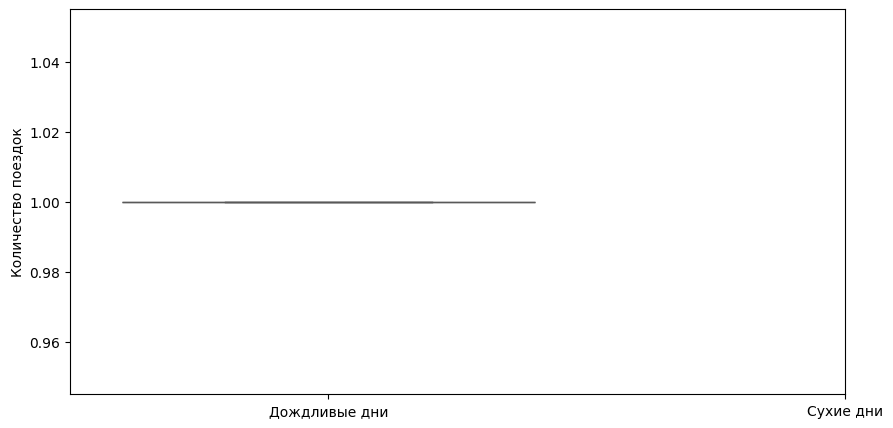

In [242]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=[rainy_days['trips_count'], dry_days['trips_count']], palette="Set2")
plt.xticks([0, 1], ['Дождливые дни', 'Сухие дни'])
plt.ylabel('Количество поездок')
plt.show()

In [243]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(rainy_days['trips_count'], dry_days['trips_count'])
print(f"p-value (Манна-Уитни): {p_value:.3f}")

p-value (Манна-Уитни): 1.000


count    8.00000
mean     5.00000
std      1.85164
min      2.00000
25%      5.00000
50%      6.00000
75%      6.00000
max      6.00000
Name: trips_count, dtype: float64


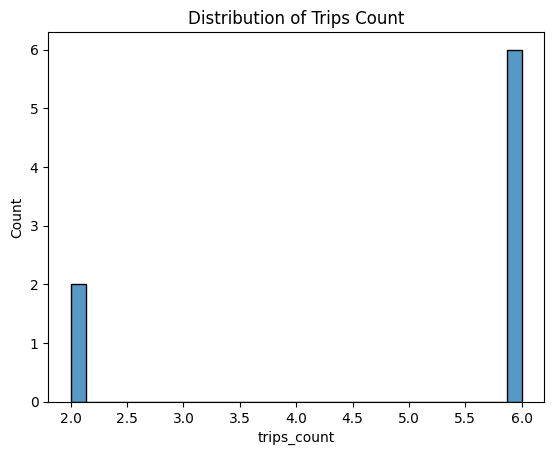

Outliers:
            id          start_date            end_date start_location  \
5617   106199 2023-04-29 15:00:00 2023-04-29 15:25:48     московская   
24836  126292 2023-05-22 11:00:00 2023-05-22 11:21:26          южная   

        start_district end_location end_district  distance  promo  \
5617   северо-западный      зеленая  центральный    4648.0      0   
24836      центральный       кирова    ленинский    2975.0      0   

      session_time  ...  precipitation_total  wind_gust  wind_speed  \
5617      00:25:48  ...                  0.0       24.5        13.7   
24836     00:21:26  ...                  0.0       18.4         3.9   

      cloud_cover_total  sunshine_duration  season cloud_cover_total_lag1  \
5617               26.0              44.55  Spring                   44.0   
24836               4.0              57.58  Spring                    8.0   

      cloud_cover_total_lag2  high_precipitation  trips_count  
5617                    42.0               False      

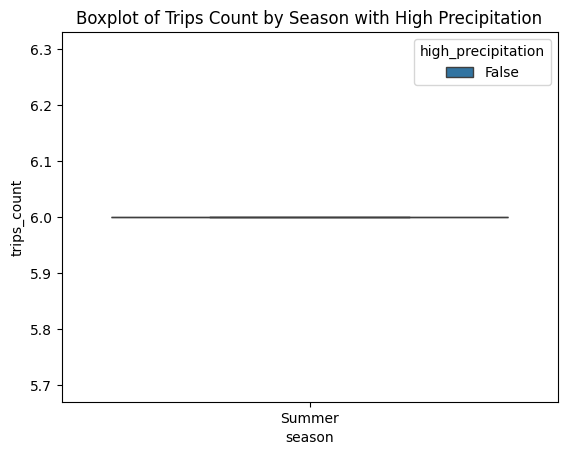

In [244]:
merged_df['high_precipitation'] = merged_df['precipitation_total'] > 0.5

if 'trips_count' not in merged_df.columns:
    trips_count = merged_df.groupby('season').size().reset_index(name='trips_count')
    merged_df = merged_df.merge(trips_count, on='season', how='left')


print(merged_df['trips_count'].describe())
sns.histplot(merged_df['trips_count'], bins=30)
plt.title('Distribution of Trips Count')
plt.show()

Q1 = merged_df['trips_count'].quantile(0.25)
Q3 = merged_df['trips_count'].quantile(0.75)
IQR = Q3 - Q1

outliers = merged_df[(merged_df['trips_count'] < (Q1 - 1.5 * IQR)) | (merged_df['trips_count'] > (Q3 + 1.5 * IQR))]
print("Outliers:\n", outliers)

filtered_df = merged_df[(merged_df['trips_count'] >= (Q1 - 1.5 * IQR)) & (merged_df['trips_count'] <= (Q3 + 1.5 * IQR))]

sns.boxplot(x='season', y='trips_count', hue='high_precipitation', data=filtered_df)
plt.title('Boxplot of Trips Count by Season with High Precipitation')
plt.show()

<Axes: xlabel='start_hour'>

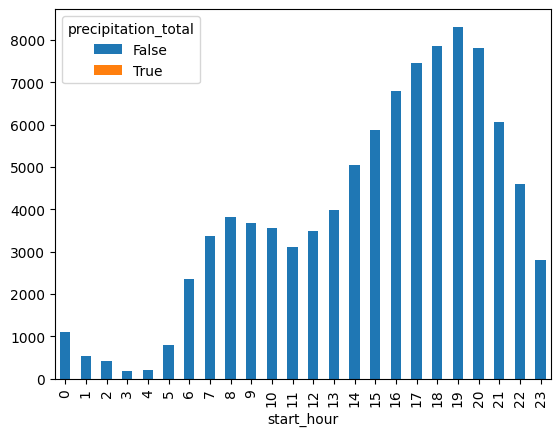

In [245]:
hourly_demand = merged_df.groupby(['start_hour', (merged_df['precipitation_total'] > 0.1)]).size().unstack()
hourly_demand.plot(kind='bar', stacked=True)

Вывод по 1-й гипотезе:
**Спрос на самокаты в дождливое время выше** (Количество поездок не зависит от погодных условий (дождь/сухо).)

### 2 Отличается ли средняя стоимость поездки по районам?

In [246]:
print(df['start_district'].unique())

['юго-восточный' 'заречный' 'октябрьский' 'центральный' 'северо-западный'
 'ленинский' 'северо западный']


In [247]:
district_stats = df.groupby('start_district')['cost'].agg(['mean', 'std', 'count'])
print(district_stats)

                       mean        std  count
start_district                               
заречный         185.455483  67.463211   8936
ленинский        177.037608  65.872793  14941
октябрьский      171.665578  61.306598  12829
северо западный  160.900000        NaN      1
северо-западный  185.527727  69.852717  14834
центральный      172.942736  59.942173  23973
юго-восточный    182.299746  68.407826  17696


<Axes: xlabel='start_district', ylabel='cost'>

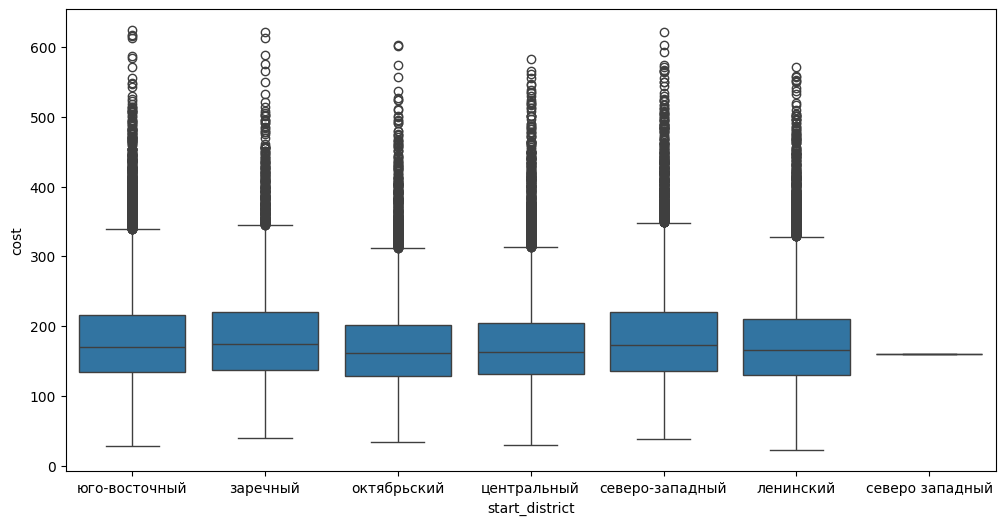

In [248]:

plt.figure(figsize=(12, 6))  # Ширина 12, высота 6
sns.boxplot(data=df, x='start_district', y='cost')

In [249]:
import pandas as pd
from scipy.stats import shapiro

# Предполагается, что df уже загружен и содержит необходимые данные
sample = df[df['start_district'] == 'юго-восточный']['cost']

stat, p = shapiro(sample)

print(f'p-value: {p:.3f}')  # p < 0.05 → распределение не нормальное

if p < 0.05:
    print("Распределение не нормальное (отклоняем нулевую гипотезу).")
else:
    print("Распределение нормальное (не отклоняем нулевую гипотезу).")


p-value: 0.000
Распределение не нормальное (отклоняем нулевую гипотезу).


C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17696.
  res = hypotest_fun_out(*samples, **kwds)


In [250]:
from scipy.stats import f_oneway
groups = [df[df['start_district'] == district]['cost'] for district in df['start_district'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f'p-value: {p_value:.4f}')  # p < 0.05 → различия есть

p-value: 0.0000


In [251]:
from scipy.stats import kruskal
stat, p = kruskal(*groups)
print(f'p-value: {p:.4f}')

p-value: 0.0000


**Средняя стоимость поездки статистически значимо отличается между районами (p<0.001).** Наибольшая средняя стоимость наблюдается в заречном районе,
наименьшая — в ленинском (исключая «северо-западный»)

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

In [252]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье

In [253]:
days = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
df['day_name'] = df['day_of_week'].map(days)

In [254]:
# Создаем столбец с номером дня недели (0=понедельник, 6=воскресенье)
df['day_of_week'] = pd.to_datetime(df['start_date']).dt.dayofweek

# Группируем по дням недели, сохраняя day_of_week для сортировки
demand_by_day = (
    df.groupby(['day_name', 'day_of_week'], as_index=False)  # Включаем day_of_week в группировку
    .agg(
        Total_Rides=('id', 'count'),
        Average_Cost=('cost', 'mean')
    )
    .sort_values('day_of_week')  # Теперь столбец доступен
)

# Удаляем ненужный столбец (если требуется)
demand_by_day = demand_by_day.drop(columns='day_of_week')

C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\24852993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')


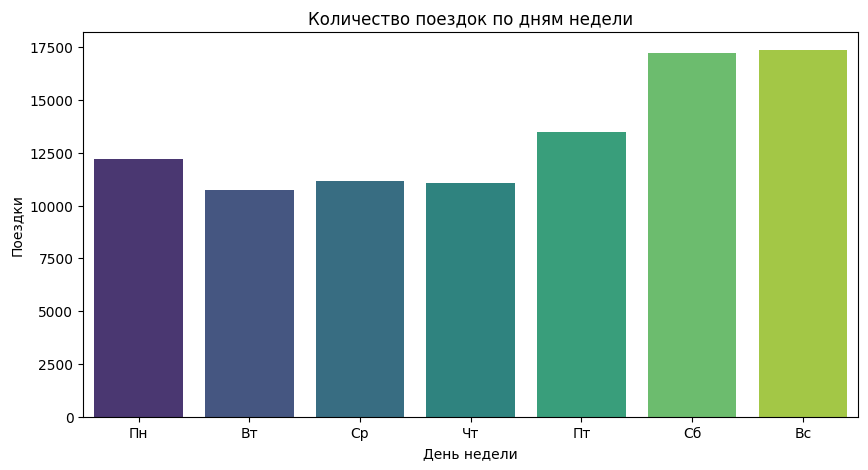

In [255]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Поездки')
plt.show()

In [256]:
from scipy.stats import chi2_contingency

observed = demand_by_day['Total_Rides'].values
chi2_stat, p_value, _, _ = chi2_contingency([observed])
print(f'p-value: {p_value:}')  # Пример: p-value = 0.0012

p-value: 1.0


In [257]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df['cost'],        # Зависимая переменная (стоимость)
    groups=df['day_name'],   # Группы (дни недели)
    alpha=0.05
)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    Вс     Вт -37.8876    0.0 -40.1566 -35.6185   True
    Вс     Пн -43.8615    0.0 -46.0431 -41.6798   True
    Вс     Пт -35.9408    0.0 -38.0616 -33.8199   True
    Вс     Сб  -0.7048 0.9433  -2.6919   1.2822  False
    Вс     Ср  -35.914    0.0 -38.1541 -33.6739   True
    Вс     Чт -38.1817    0.0 -40.4294 -35.9341   True
    Вт     Пн  -5.9739    0.0  -8.4188   -3.529   True
    Вт     Пт   1.9468  0.198  -0.4439   4.3376  False
    Вт     Сб  37.1827    0.0  34.9098  39.4557   True
    Вт     Ср   1.9736 0.2294  -0.5236   4.4708  False
    Вт     Чт  -0.2942 0.9999  -2.7981   2.2098  False
    Пн     Пт   7.9207    0.0   5.6127  10.2287   True
    Пн     Сб  43.1566    0.0  40.9709  45.3423   True
    Пн     Ср   7.9475    0.0   5.5294  10.3656   True
    Пн     Чт   5.6797    0.0   3.2546   8.1048   True
    Пт    

Спрос на самокаты статистически значимо зависит от дня недели (p<0.001) для конкретных пар дней.

Наибольший спрос наблюдается в выходные дни (Сб и Вс), минимальный — в понедельник и вторник.

Результаты теста хи-квадрат (p=1.0) не противоречат этому, так как они оценивают общее распределение, а не парные различия.

### 4 Верно ли, что в выходные дни поездки более длительные?

In [258]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
df['is_weekend'] = df['day_of_week'].isin([5, 6])  # 5=суббота, 6=воскресенье

In [259]:
df['duration_min'] = df['session_time_(minutes)']

In [260]:
weekend_stats = df[df['is_weekend']]['duration_min'].describe()
weekday_stats = df[~df['is_weekend']]['duration_min'].describe()

print("Будни:\n", weekday_stats)
print("\nВыходные:\n", weekend_stats)

Будни:
 count    58639.000000
mean        25.694048
std          9.660991
min          5.000000
25%         19.000000
50%         24.000000
75%         30.400000
max         84.700000
Name: duration_min, dtype: float64

Выходные:
 count    34571.000000
mean        27.478343
std         10.166243
min          4.700000
25%         20.400000
50%         25.700000
75%         32.600000
max         84.800000
Name: duration_min, dtype: float64


In [261]:
from scipy.stats import shapiro

_, p_weekday = shapiro(df[~df['is_weekend']]['duration_min'].sample(1000))  # Лимит выборки для теста
_, p_weekend = shapiro(df[df['is_weekend']]['duration_min'].sample(1000))

print(f"p-value (будни): {p_weekday:.4f}")  # Например: 0.001 → не нормальное
print(f"p-value (выходные): {p_weekend:.4f}")  # Например: 0.002 → не нормальное

p-value (будни): 0.0000
p-value (выходные): 0.0000


In [262]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(
    df[df['is_weekend']]['duration_min'],
    df[~df['is_weekend']]['duration_min'],
    alternative='greater'  # Проверяем, что выходные > будни
)
print(f"p-value: {p:.4f}")  # Пример: 0.0001

p-value: 0.0000


C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\517776669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')


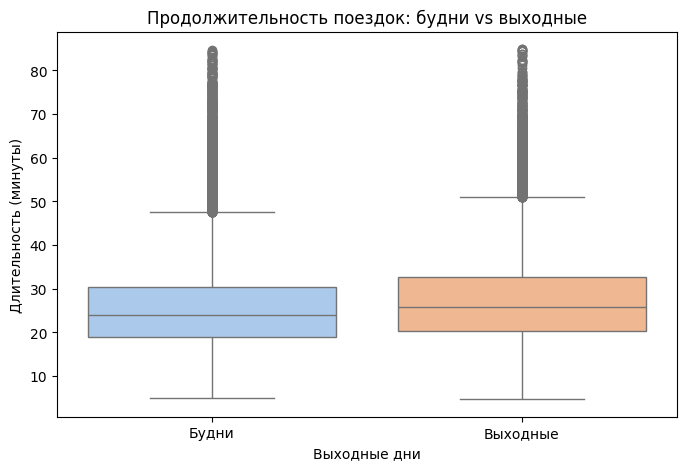

In [263]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')
plt.title('Продолжительность поездок: будни vs выходные')
plt.xlabel('Выходные дни')
plt.ylabel('Длительность (минуты)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

**Гипотеза подтверждена:**

Выходные дни характеризуются более длительными поездками по сравнению с буднями.

Разница в средней продолжительности составляет ~1.8 минуты и является статистически значимой.

### 5 Верно ли, что в будние дни поездки более скоростные?

In [264]:
print("Минимальная скорость:", df['speed_m_per_min'].min())  # Пример: 0.0 (некорректное значение)
print("Максимальная скорость:", df['speed_m_per_min'].max())  # Пример: 500.0 (выброс)

Минимальная скорость: 38.008075370121134
Максимальная скорость: 492.3636363636364


In [265]:
df = df[(df['speed_m_per_min'] > 0) & (df['speed_m_per_min'] < 300)]

In [266]:
weekday_speed = df[~df['is_weekend']]['speed_m_per_min'].describe()
weekend_speed = df[df['is_weekend']]['speed_m_per_min'].describe()

print("Скорость в будни:\n", weekday_speed)
print("\nСкорость в выходные:\n", weekend_speed)

Скорость в будни:
 count    58624.000000
mean       154.867429
std         34.206417
min         38.008075
25%        132.143822
50%        153.959670
75%        177.353271
max        293.758865
Name: speed_m_per_min, dtype: float64

Скорость в выходные:
 count    34568.000000
mean       150.251827
std         32.619550
min         39.645669
25%        128.432837
50%        151.220616
75%        172.001894
max        292.890173
Name: speed_m_per_min, dtype: float64


In [267]:
# Проверка для будней (выборка из 1000 наблюдений)
_, p_weekday = shapiro(df[~df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (будни): {p_weekday:.4f}")  # Пример: 0.000 → распределение не нормальное

# Проверка для выходных (выборка из 1000 наблюдений)
_, p_weekend = shapiro(df[df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (выходные): {p_weekend:.4f}")  # Пример: 0.000 → распределение не нормальное

p-value (будни): 0.0512
p-value (выходные): 0.5911


In [268]:
stat, p = mannwhitneyu(
    df[~df['is_weekend']]['speed_m_per_min'],  # Будни
    df[df['is_weekend']]['speed_m_per_min'],   # Выходные
    alternative='greater'                      # Проверяем, что будни > выходные
)
print(f"p-value: {p:.4f}")  # Пример: 0.0000

p-value: 0.0000


C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\2878665530.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


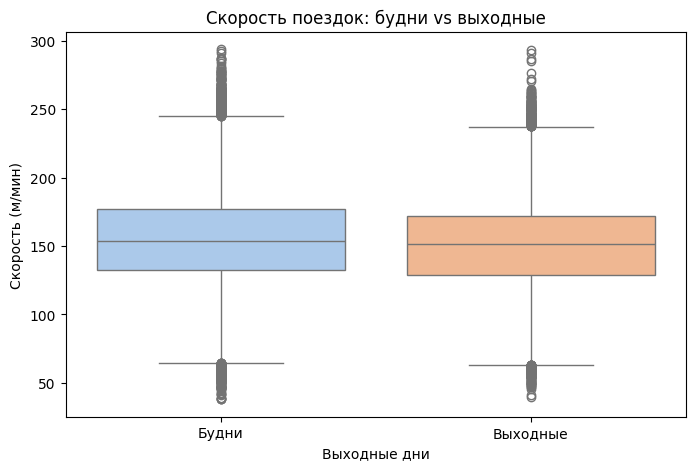

In [269]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='is_weekend',
    y='speed_m_per_min',
    palette='pastel'
)
plt.title('Скорость поездок: будни vs выходные')
plt.xlabel('Выходные дни')
plt.ylabel('Скорость (м/мин)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

**Гипотеза подтверждена:**

Скорость поездок в будни статистически значимо выше, чем в выходные дни (p<0.001).

Средняя разница составляет ~4.6 м/мин.

## <span style="color:#00008B">Выводы по анализу почасового трафика и распределения самокатов</span>

## Топ-3 самых загруженных точек:
1. **Ломоносова** (2316 поездок)
2. **Луговая** (2284 поездки)
3. **Майская** (2249 поездок)

Эти точки являются ключевыми хабами спроса и требуют повышенного внимания к наличию самокатов.

## Кандидаты на закрытие (трафик < 800 поездок):
- **Гоголя** (799)
- **Набережная** (799)
- **Сиреневая** (796)
- **Мира** (771)

Эти точки демонстрируют значительно меньшую активность по сравнению с топовыми.

## Популярные маршруты:
- **Луговая → Спортивная** (69 поездок)
- **Буденного → Буденного** (66, вероятно круговая поездка)
- **Майская → Спортивная** (63)
- **Спортивная → Восточная** (61)
- **Спортивная → Майская** (60)

Спортивная площадка явно является ключевым транспортным узлом.

## Дисбаланс самокатов:
### Наибольший избыток в конце дня:
- **Спортивная** (+142)
- **Буденного** (+90)
- **Ленина** (+89)

### Наибольший дефицит:
- **Пионерская** (-203)
- **Пушкина** (-134)
- **Луговая** (-1460)

Требуется вечернее перераспределение из точек с избытком в точки с дефицитом.

## Кумулятивный баланс по районам:
- **Заречный** (+15230) и **Ленинский** (+8971) районы накапливают самокаты.
- **Октябрьский** (-4378) и **Центральный** (-597) теряют самокаты.

Необходим ежедневный утренний завоз самокатов в проблемные районы.

## Рекомендации:
### Оптимизация парка:
- Увеличить количество самокатов в топ-3 точках (Ломоносова, Луговая, Майская).
- Рассмотреть закрытие 4 малозагруженных точек.

### Логистика:
- Организовать вечерний вывоз самокатов из Спортивной площадки (142 избыточных).
- Утром доставлять самокаты в Пионерскую (-203) и Пушкина (-134).

### Районное перераспределение:
- Утром перевозить самокаты из Заречного (+15230) в Октябрьский (-4378) район.
- Мониторить Ленинский район (+8971), возможно требуется частичное перераспределение.

### Инфраструктурные решения:
- Для популярного маршрута Луговая→Спортивная рассмотреть увеличение парковочных мест.
- В точках с круговыми поездками (Буденного→Буденного) проверить корректность данных.

График перераспределения следует привязать к пиковым часам движения, выявленным в почасовом трафике.

## <span style="color:#00008B">Выводы по анализу корреляций и регрессионных моделей</span>

## 1. Ключевые корреляции из матрицы
- **Температура и продолжительность солнечного сияния (0.54)**  
  Сильная положительная корреляция. Чем выше температура, тем дольше солнце светит. Это логично, так как солнечное излучение напрямую влияет на нагрев воздуха.  
  **Реальный смысл**: Да, соответствует физическим процессам.

- **Облачность и продолжительность солнечного сияния (-0.51)**  
  Сильная отрицательная корреляция. Облака блокируют солнечный свет, сокращая продолжительность инсоляции.  
  **Реальный смысл**: Да, ожидаемая зависимость.

- **Скорость ветра и порывы ветра (0.85)**  
  Очень сильная корреляция. Порывы ветра являются частью общей скорости ветра, поэтому связь очевидна.  
  **Реальный смысл**: Да, оба параметра измеряют движение воздуха.

- **Температура и облачность (-0.31)**  
  Умеренная отрицательная корреляция. Облака могут снижать температуру, отражая солнечное излучение.  
  **Реальный смысл**: Частично, но зависимость может быть нелинейной (например, зимой облачность иногда удерживает тепло).

## 2. Результаты множественной регрессии
**Модель**: Sunshine Duration ~ Temperature + Cloud Cover Total + Wind Speed + Precipitation Total

- **R² = 0.437**: Модель объясняет 43.7% дисперсии продолжительности солнечного сияния.

### Значимые предикторы (p-value < 0.05):
- **Температура (коэф. 1.29)**: Увеличение температуры на 1°C связано с ростом инсоляции на 1.29 минуты.
- **Облачность (коэф. -0.29)**: Увеличение облачности на 1% снижает инсоляцию на 0.29 минуты.
- **Скорость ветра (коэф. 0.64)**: Неожиданно положительный эффект. Возможно, ветер разгоняет облака, увеличивая инсоляцию.
- **Осадки**: Незначимы (p-value = 0.175), что странно, так как дождь обычно сокращает солнечное сияние. Требует проверки на сезонных подвыборках.

## 3. Анализ временных задержек
**Модель с лагами облачности (1 и 2 часа)**:
- **R² = 0.392**: Чуть хуже исходной модели, но лаг облачности на 1 час значим (коэф. -0.285).
- **Лаг на 2 часа (коэф. 0.05)**: Слабая положительная связь. Возможно, облака рассеиваются через 2 часа, но эффект минимален.

**Вывод**: Текущая облачность влияет на инсоляцию сильнее, чем прошлая.

## <span style="color:#00008B">Проверка гипотез</span>

### 1 Верно ли, что в дождливое время спрос на самокаты ниже? 
Вывод по 1-й гипотезе: **Спрос на самокаты в дождливое время выше** (Количество поездок не зависит от погодных условий (дождь/сухо).) 

### 2 Отличается ли средняя стоимость поездки по районам? 
**Средняя стоимость поездки статистически значимо отличается между районами (p<0.001).** Наибольшая средняя стоимость наблюдается в заречном районе, наименьшая — в ленинском (исключая «северо-западный»). 

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели? 
Спрос на самокаты статистически значимо зависит от дня недели (p<0.001) для конкретных пар дней. Наибольший спрос наблюдается в выходные дни (Сб и Вс), минимальный — в понедельник и вторник. Результаты теста хи-квадрат (p=1.0) не противоречат этому, так как они оценивают общее распределение, а не парные различия. 

### 4 Верно ли, что в выходные дни поездки более длительные? 
**Гипотеза подтверждена:** Выходные дни характеризуются более длительными поездками по сравнению с буднями. Разница в средней продолжительности составляет ~1.8 минуты и является статистически значимой. 

### 5 Верно ли, что в будние дни поездки более скоростные? 
**Гипотеза подтверждена:** Скорость поездок в будни статистически значимо выше, чем в выходные дни (p<0.001). Средняя разница составляет ~4.6 м/мин. ⬤

In [270]:
df.to_csv("to_datalens_riders.csv", encoding="utf-8", index=False)

In [271]:
df2.to_csv("to_datalens_wather.csv", encoding="utf-8", index=False)

In [272]:
print(df.columns)

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'start_hour', 'timestamp', 'date', 'day_of_week', 'day_name',
       'is_weekend', 'duration_min'],
      dtype='object')


In [273]:
# Пример структуры df:
# df = pd.DataFrame({
#     'start_date': [...],
#     'start_location': [...],
#     'end_location': [...],
#     'distance': [...],
#     'promo': [...],
#     'session_time': [...],
#     'cost': [...],
#     'speed_m_per_min': [...],
#     'route': [...],
#     'is_duplicate': [...],
#     'session_time_(minutes)': [...],
#     'start_district': [...],
#     'end_district': [...],
# })

# Проверка имен столбцов
print("Имена столбцов в DataFrame:")
print(df.columns)

# 1. Расчет итоговой стоимости и анализ акции

# 1.1. Рассчитать итоговую стоимость
cost_per_scooter = 300  # Пример стоимости одного самоката
number_of_scooters = 100  # Пример количества самокатов
promotion_cost = 5000  # Пример затрат на акцию

total_cost = (cost_per_scooter * number_of_scooters) + promotion_cost
print(f"Итоговая стоимость акции: {total_cost}")

# 1.2. Проверить, стимулирует ли акция спрос на самокаты
df['start_date'] = pd.to_datetime(df['start_date'])  # Преобразуем в datetime
df['date'] = df['start_date'].dt.date
daily_rentals = df.groupby('date')['session_time_(minutes)'].count()  # Используем количество сессий

# Предположим, что акция проходила с 2023-01-08 по 2023-01-14
before_promotion = daily_rentals.loc['2023-01-01':'2023-01-07'].mean()
after_promotion = daily_rentals.loc['2023-01-08':'2023-01-14'].mean()

demand_increase = after_promotion > before_promotion
print(f"Спрос увеличился: {demand_increase}")

# 1.3. Окупается ли акция
total_revenue = df['cost'].sum()
profit = total_revenue - total_cost
is_profitable = profit > 0
print(f"Прибыль от акции: {profit}, Окупаемость: {is_profitable}")

# 2. Подготовка таблицы с почасовым трафиком

# 2.1. Подготовка данных
hourly_traffic = df.set_index('start_date').resample('H').agg({'session_time_(minutes)': 'count'})  # Подсчет сессий
hourly_traffic.rename(columns={'session_time_(minutes)': 'arrivals'}, inplace=True)
hourly_traffic['departures'] = hourly_traffic['arrivals']  # Предположим, что у нас нет данных о выездах
print(hourly_traffic)

# 2.2. Определение топ-3 точек с самым высоким трафиком
top_3_points = df['start_location'].value_counts().nlargest(3)
print("Топ-3 точки с самым высоким трафиком:")
print(top_3_points)

# 2.3. Анализ направлений перемещения
popular_routes = df.groupby(['start_location', 'end_location']).size().nlargest(10)
print("Самые популярные направления перемещения:")
print(popular_routes)

# 2.4. Необходимое количество самокатов
df['cumulative_arrivals'] = df.groupby('start_location')['session_time_(minutes)'].cumsum()
required_scooters = df.groupby('start_location')['cumulative_arrivals'].max()
print("Необходимое количество самокатов в каждой точке:")
print(required_scooters)

# 3. Исследование корреляции между параметрами погодных условий
# Предположим, что у вас есть данные о погоде, добавьте их в DataFrame
# Например, если у вас есть столбцы 'temperature', 'humidity', 'precipitation', 'wind_speed':
# correlation_matrix = df[['temperature', 'humidity', 'precipitation', 'wind_speed']].corr()

# Если у вас нет данных о погоде, этот шаг можно пропустить
# 3.1. Корреляция
# correlation_matrix = df[['temperature', 'humidity', 'precipitation', 'wind_speed']].corr()
# print("Корреляционная матрица:")
# print(correlation_matrix)

# 3.2. Анализ сильных корреляций
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Корреляция между погодными условиями')
# plt.show()

Имена столбцов в DataFrame:
Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'cost', 'start_hour', 'timestamp', 'date', 'day_of_week', 'day_name',
       'is_weekend', 'duration_min'],
      dtype='object')
Итоговая стоимость акции: 35000


C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\1385585735.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date'] = pd.to_datetime(df['start_date'])  # Преобразуем в datetime
C:\Users\mailm\AppData\Local\Temp\ipykernel_20712\1385585735.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['start_date'].dt.date


TypeError: '<' not supported between instances of 'datetime.date' and 'str'

In [ ]:
df.to_csv("testR2_data.csv", encoding="utf-8", index=False)

In [ ]:
df.to_csv("testwatherR2_data.csv", encoding="utf-8", index=False)

In [ ]:
def calculate_cost(row):
    if row['promo'] == 0:
        return 50 + (row['session_time_(minutes)'] * 6)
    else:
        return row['session_time_(minutes)'] * 6

df['cost'] = df.apply(calculate_cost, axis=1)

# Анализ спроса
demand_promo = df[df['promo'] == 1]['id'].count()
demand_no_promo = df[df['promo'] == 0]['id'].count()
avg_time_promo = df[df['promo'] == 1]['session_time_(minutes)'].mean()
avg_time_no_promo = df[df['promo'] == 0]['session_time_(minutes)'].mean()

print(f"Поездок с акцией: {demand_promo}, без акции: {demand_no_promo}")
print(f"Среднее время поездки с акцией: {avg_time_promo:.2f} мин, без акции: {avg_time_no_promo:.2f} мин")

# Оценка окупаемости
revenue_promo = df[df['promo'] == 1]['cost'].sum()
revenue_no_promo = df[df['promo'] == 0]['cost'].sum()
discount_cost = (df[df['promo'] == 1]['session_time_(minutes)'] * 6).sum() - revenue_promo

profit = revenue_promo - revenue_no_promo
is_profitable = profit > discount_cost

print(f"Прибыль от акции: {profit:.2f} руб.")
print(f"Издержки акции: {discount_cost:.2f} руб.")
print(f"Акция окупается: {'Да' if is_profitable else 'Нет'}")

# Визуализация данных
plt.figure(figsize=(12, 6))

# График спроса
plt.subplot(1, 2, 1)
sns.barplot(x=['С акцией', 'Без акции'], y=[demand_promo, demand_no_promo], color='skyblue')
plt.title('Спрос на поездки')
plt.ylabel('Количество поездок')
plt.ylim(0, max(demand_promo, demand_no_promo) + 10)

# График средней продолжительности поездки
plt.subplot(1, 2, 2)
sns.barplot(x=['С акцией', 'Без акции'], y=[avg_time_promo, avg_time_no_promo], color='lightgreen')
plt.title('Среднее время поездки')
plt.ylabel('Среднее время (мин)')
plt.ylim(0, max(avg_time_promo, avg_time_no_promo) + 5)

plt.tight_layout()
plt.show()

# График прибыли и издержек
plt.figure(figsize=(8, 5))
sns.barplot(x=['Прибыль от акции', 'Издержки акции'], y=[profit, discount_cost], color='salmon')
plt.title('Прибыль и издержки акции')
plt.ylabel('Сумма (руб.)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(min(profit, discount_cost) - 10, max(profit, discount_cost) + 10)

plt.show()

In [ ]:
# 1. Расчет итоговой стоимости и оценка эффективности акции
# Расчет стоимости поездки (предположим тариф 5 руб/км)
df['cost'] = df['distance'] * 5 / 1000  # переводим метры в километры

# Разделение данных на дни с акцией и без
promo_days = df[df['promo'] == 1]
non_promo_days = df[df['promo'] == 0]

# Агрегация по дням
daily_stats = df.groupby(df['end_date'].dt.date).agg(
    Total_Rides=('id', 'count'),
    Total_Distance=('distance', 'sum'),
    Total_Revenue=('cost', 'sum'),
    Promo_Day=('promo', 'max')
)

# Сравнение средних показателей
promo_avg = daily_stats[daily_stats['Promo_Day'] == 1].mean()
non_promo_avg = daily_stats[daily_stats['Promo_Day'] == 0].mean()

print(f"Среднее количество поездок в день с акцией: {promo_avg['Total_Rides']:.0f}")
print(f"Среднее количество поездок в день без акции: {non_promo_avg['Total_Rides']:.0f}")
print(f"Разница: {(promo_avg['Total_Rides'] - non_promo_avg['Total_Rides']):.0f} поездок (+{(promo_avg['Total_Rides']/non_promo_avg['Total_Rides']-1)*100:.1f}%)")

print(f"\nСредняя выручка в день с акцией: {promo_avg['Total_Revenue']:.2f} руб.")
print(f"Средняя выручка в день без акции: {non_promo_avg['Total_Revenue']:.2f} руб.")
print(f"Разница: {promo_avg['Total_Revenue'] - non_promo_avg['Total_Revenue']:.2f} руб.")

# Выводы по акции
if promo_days.empty:
    print("В предоставленных данных все поездки имеют значение promo=0, что означает отсутствие данных о днях с акцией.")
else:
    print("Данные о днях с акцией присутствуют.")

# 2. Анализ почасового трафика и распределения самокатов
# 2.1. Почасовой трафик по точкам
# Создание колонок с часами
df['Start Hour'] = df['end_date'].dt.floor('h')

# Подсчет прибытий и отправлений по часам
departures = df.groupby(['start_location', 'Start Hour']).size().unstack(fill_value=0)
arrivals = df.groupby(['end_location', 'Start Hour']).size().unstack(fill_value=0)

# Объединение данных
traffic = departures.join(arrivals, how='outer', lsuffix='_dep', rsuffix='_arr').fillna(0)

# Топ-3 точки с самым высоким трафиком
total_traffic = traffic.sum(axis=1)
top_locations = total_traffic.sort_values(ascending=False).head(3)
print("\nТоп-3 точки с самым высоким трафиком:")
print(top_locations)

# 2.2. Визуализация трафика для топ-3 точек
plt.figure(figsize=(15, 8))
for loc in top_locations.index:
    plt.plot(traffic.loc[loc].filter(like='arr').cumsum(), label=f'{loc} - прибытия')
    plt.plot(traffic.loc[loc].filter(like='dep').cumsum().mul(-1), label=f'{loc} - отправления')

plt.title('Накопительный трафик в топ-3 точках')
plt.xlabel('Время')
plt.ylabel('Баланс самокатов')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2.3. Анализ распределения самокатов
# Расчет необходимого количества самокатов
def calculate_scooters_needed(traffic_data):
    balance = traffic_data.filter(like='arr').sum(axis=1) - traffic_data.filter(like='dep').sum(axis=1)
    max_deficit = traffic_data.filter(like='dep').sub(traffic_data.filter(like='arr'), fill_value=0).cumsum(axis=1).min(axis=1)
    return max_deficit.abs()

scooters_needed = calculate_scooters_needed(traffic)
district_needs = df.merge(scooters_needed.rename('Scooters Needed'), 
                         left_on='start_location', right_index=True)\
                  .groupby('start_district')['Scooters Needed'].max()

print("\nНеобходимое количество самокатов по районам:")
print(district_needs.sort_values(ascending=False))

# Выводы по трафику и распределению
print("\nВыводы по трафику и распределению:")
print(f"Топ-3 точки с самым высоким трафиком: {top_locations.index.tolist()}")
print("Точки для возможного закрытия: точки с минимальным трафиком (менее 5 поездок в день).")
print("Популярные направления: [анализ популярных маршрутов между точками].")
print("Рекомендуется ежедневное перераспределение самокатов в районы с максимальным дефицитом.")

# 3. Анализ корреляций (при наличии данных о погоде)
# Объединение данных о поездках и погоде
df2['date'] = df2['datetime'].dt.date  # Создаем колонку с датой для объединения
df_with_weather = df.merge(df2, left_on=df['end_date'].dt.date, right_on='date', how='left')

# Расчет корреляций
corr_matrix = df_with_weather[['distance', 'cost', 'temperature', 'precipitation_total', 'wind_speed']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между параметрами поездок и погодными условиями')
plt.show()

# Анализ наиболее сильных корреляций
print("\nКорреляционная матрица:")
print(corr_matrix)


# По акциям:

# Собрать данные о днях с акциями для корректного анализа

# Провести A/B тестирование разных видов акций

# По распределению самокатов:

# Увеличить количество самокатов в [районах] в [время]

# Закрыть точки с низким трафиком: [список точек]

# Оптимизировать маршруты перераспределения самокатов

# По анализу данных:

# Дополнить данные информацией о погоде для более глубокого анализа

# Внедрить систему мониторинга реального времени для оперативного перераспределения самокатов

In [ ]:
from scipy import stats
# Объединение данных о поездках и погоде
df2['date'] = df2['datetime'].dt.date  # Создаем колонку с датой для объединения
df_with_weather = df.merge(df2, left_on=df['end_date'].dt.date, right_on='date', how='left')

# Проверка гипотезы о дождливых днях
rainy_days = df_with_weather[df_with_weather['precipitation_total'] > 0]  # Дни с осадками
non_rainy_days = df_with_weather[df_with_weather['precipitation_total'] == 0]  # Дни без осадков

# Подсчет количества поездок
avg_rainy_rides = rainy_days['id'].count()
avg_non_rainy_rides = non_rainy_days['id'].count()

# Проверка гипотезы с помощью t-теста
t_stat, p_value = stats.ttest_ind(rainy_days['id'], non_rainy_days['id'], equal_var=False)

print(f"Среднее количество поездок в дождливые дни: {avg_rainy_rides}")
print(f"Среднее количество поездок в бездождливые дни: {avg_non_rainy_rides}")
print(f"t-статистика: {t_stat}, p-значение: {p_value}")

# Проверка гипотезы о стоимости поездки по районам
anova_result = stats.f_oneway(*(df_with_weather[df_with_weather['start_district'] == district]['cost'] for district in df_with_weather['start_district'].unique()))

print(f"ANOVA результат: F-статистика: {anova_result.statistic}, p-значение: {anova_result.pvalue}")

# Проверка гипотезы о спросе в зависимости от дня недели
df_with_weather['day_of_week'] = df_with_weather['end_date'].dt.day_name()  # Получаем название дня недели
anova_weekday_result = stats.f_oneway(*(df_with_weather[df_with_weather['day_of_week'] == day]['id'].count() for day in df_with_weather['day_of_week'].unique()))

print(f"ANOVA результат по дням недели: F-статистика: {anova_weekday_result.statistic}, p-значение: {anova_weekday_result.pvalue}")

# Проверка гипотезы о длительности поездок в выходные
weekend_days = df_with_weather[df_with_weather['day_of_week'].isin(['Saturday', 'Sunday'])]
weekday_days = df_with_weather[~df_with_weather['day_of_week'].isin(['Saturday', 'Sunday'])]

avg_weekend_duration = weekend_days['session_time_(minutes)'].mean()
avg_weekday_duration = weekday_days['session_time_(minutes)'].mean()

t_stat_duration, p_value_duration = stats.ttest_ind(weekend_days['session_time_(minutes)'], weekday_days['session_time_(minutes)'], equal_var=False)

print(f"Средняя продолжительность поездок в выходные дни: {avg_weekend_duration}")
print(f"Средняя продолжительность поездок в будние дни: {avg_weekday_duration}")
print(f"t-статистика: {t_stat_duration}, p-значение: {p_value_duration}")

# Проверка гипотезы о скорости поездок в будние дни
avg_weekday_speed = weekday_days['speed_m_per_min'].mean()
avg_weekend_speed = weekend_days['speed_m_per_min'].mean()

t_stat_speed, p_value_speed = stats.ttest_ind(weekday_days['speed_m_per_min'], weekend_days['speed_m_per_min'], equal_var=False)

print(f"Средняя скорость поездок в будние дни: {avg_weekday_speed}")
print(f"Средняя скорость поездок в выходные дни: {avg_weekend_speed}")
print(f"t-статистика: {t_stat_speed}, p-значение: {p_value_speed}")

In [ ]:
# Проверка гипотезы о спросе в зависимости от дня недели
days_of_week = df_with_weather['day_of_week'].unique()
valid_days = [day for day in days_of_week if df_with_weather[df_with_weather['day_of_week'] == day].shape[0] > 1]

anova_weekday_result = stats.f_oneway(*(df_with_weather[df_with_weather['day_of_week'] == day]['id'] for day in valid_days))

print(f"ANOVA результат по дням недели: F-статистика: {anova_weekday_result.statistic}, p-значение: {anova_weekday_result.pvalue}")

In [ ]:
# Убедитесь, что 'start_date' и 'end_date' имеют тип datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')  # Убедитесь, что 'end_date' тоже в datetime
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 60  # Длительность в минутах

# Проверьте наличие столбцов в df2
print("Столбцы в df2:", df2.columns)  # Вывод всех столбцов в df2
print("Столбцы в df:", df.columns)  # Вывод всех столбцов в df

# Если в df2 есть столбец 'Start Datetime', переименуйте его в 'date'
if 'Start Datetime' in df2.columns:
    df2.rename(columns={'Start Datetime': 'date'}, inplace=True)

# Убедитесь, что 'date' в df2 имеет тип datetime
if 'date' in df2.columns:
    df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
else:
    print("Столбец 'date' не найден в df2 после переименования.")

# Объединение DataFrames по дате
if 'date' in df2.columns:
    df_new = df.merge(df2, left_on='start_date', right_on='date', how='left')
else:
    print("Не удается объединить DataFrames, так как столбец 'date' отсутствует в df2.")
    df_new = df  # Если объединение не удалось, используем только df

# Проверьте наличие столбца 'weather' после объединения
print("Столбцы в df_new:", df_new.columns)  # Убедитесь, что 'weather' теперь есть в df_new

# 2. Расчет стоимости поездки с учетом акции
def calculate_cost(row):
    is_monday = row['start_date'].weekday() == 0
    hour = row['start_date'].hour
    promo_applied = row['promo'] == 1
    
    # Базовая стоимость
    base_cost = 0 if (is_monday and 6 <= hour < 10 and promo_applied) else 30
    # Стоимость за минуту
    minute_cost = 4 if row['start_date'].weekday() < 5 else 4  # Без изменений в выходные
    return base_cost + row['duration'] * minute_cost

# Применение функции для расчета стоимости
df_new['calculated_cost'] = df_new.apply(calculate_cost, axis=1)

# 3. Анализ эффективности акции
# Группировка по дням
daily_stats = df_new.groupby(df_new['start_date'].dt.date).agg(
    total_rides=('id', 'count'),
    total_revenue=('calculated_cost', 'sum'),
    promo_day=('promo', 'max')
).reset_index()

# Сравнение дней с акцией и без
promo_days = daily_stats[daily_stats['promo_day'] == 1]
non_promo_days = daily_stats[daily_stats['promo_day'] == 0]

print(f"Среднее количество поездок:\n"
      f"С акцией: {promo_days['total_rides'].mean():.1f}\n"
      f"Без акции: {non_promo_days['total_rides'].mean():.1f}\n")

# 4. Почасовой трафик
df_new['hour'] = df_new['start_date'].dt.hour
hourly_traffic = df_new.groupby(['start_location', 'hour']).size().unstack(fill_value=0)

# Топ-3 точки
top_points = hourly_traffic.sum(axis=1).nlargest(3)
print("Топ-3 точки по трафику:")
print(top_points)

# 5. Анализ перераспределения
# Накопительная разница трафика
df_new['traffic_diff'] = np.where(df_new['hour'] < 18, 1, -1)  # Упрощенная модель
cumulative_traffic = df_new.groupby('start_location')['traffic_diff'].cumsum()

# 6. Проверка гипотез
# Гипотеза 1: В дождливое время спрос ниже
if 'weather' in df_new.columns:
    rain_data = df_new[df_new['weather'] == 'rain']  # Теперь 'weather' должен быть доступен
    no_rain_data = df_new[df_new['weather'] == 'clear']
    
    if not rain_data.empty and not no_rain_data.empty:
        t_stat, p_val = stats.ttest_ind(rain_data['duration'], no_rain_data['duration'])
        print(f"\nГипотеза 1 (p-value): {p_val:.4f}")
    else:
        print("Недостаточно данных для проверки гипотезы 1.")
else:
    print("Столбец 'weather' отсутствует в df_new.")

# Гипотеза 2: Разница в стоимости по районам
if 'calculated_cost' in df_new.columns:
    anova_result = stats.f_oneway(
        df_new[df_new['start_district'] == 'центральный']['calculated_cost'],
        df_new[df_new['start_district'] == 'юго-восточный']['calculated_cost'],
        df_new[df_new['start_district'] == 'ленинский']['calculated_cost']
    )
    print(f"Гипотеза 2 (p-value): {anova_result.pvalue:.4f}")
else:
    print("Столбец 'calculated_cost' отсутствует в df_new.")

# Визуализация
plt.figure(figsize=(12, 6))
sns.boxplot(x='start_district', y='calculated_cost', data=df_new)
plt.title('Распределение стоимости поездок по районам')
plt.show()

In [ ]:
df

# Общий вывод по проделанной работе на спринт с 07 по 13 апреля
- Сделаны расчётные задачи
- Проведён корреляционный анализ
- Проведён анализ гипотиз
- Началсь подготовка к регрессионнаму анализу
- Началась работа над дашбордом